<a href="https://colab.research.google.com/github/TomohiroYazaki/UW-Madison_GI_Tract_Image_Segmentation/blob/main/UW_Madison_GI_Tract_Image_Segmentation_v9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**---------- Import ----------**

In [17]:
DATASET = "0_-1_1_-2_2"
DRIVE_PATH = "/content/drive/MyDrive/Kaggle/UW-Madison_GI_Tract_Image_Segmentation/Data/UWMGI_2.5D_Dataset_" + DATASET + ".zip" 
CURRENT_PATH = "/content/UWMGI_2.5D_Dataset_" + DATASET + ".zip"

In [18]:
#!rm -f -r /content/DATA
#![ -r /content/DATA ] && rm -f -r /content/DATA
!rm -f -r /content/OUTPUT
!rm -f -r /content/OUTPUT/MODEL

In [19]:
#!mkdir DATA
![ -r /content/DATA ] || mkdir DATA
!mkdir OUTPUT
!mkdir OUTPUT/MODEL

In [20]:
#%%time
#!mkdir DATA/MASK
#!cp /content/drive/MyDrive/Kaggle/UW-Madison_GI_Tract_Image_Segmentation/Data/UWMGI_Mask_Dataset_20220501.zip /content/
#!unzip -qq /content/UWMGI_Mask_Dataset_20220501.zip -d /content/DATA/MASK
#!rm /content/UWMGI_Mask_Dataset_20220501.zip

#!mkdir DATA/ORIGINAL
#!cp /content/drive/MyDrive/Kaggle/UW-Madison_GI_Tract_Image_Segmentation/Data/original.zip /content/
#!unzip -qq /content/original.zip -d /content/DATA/ORIGINAL
#!rm /content/original.zip

In [21]:
%%time
#!cp /content/drive/MyDrive/Kaggle/UW-Madison_GI_Tract_Image_Segmentation/Data/UWMGI_2.5D_Dataset_0_-1_1_-2_2_-3_3.zip /content/
#!unzip -qq /content/UWMGI_2.5D_Dataset_0_-1_1_-2_2_-3_3.zip -d /content/DATA
#!rm /content/UWMGI_2.5D_Dataset_0_-1_1_-2_2_-3_3.zip
![ -f /content/DATA/train.csv ] || cp $DRIVE_PATH $CURRENT_PATH
![ -f $CURRENT_PATH ] && unzip -qq $CURRENT_PATH -d /content/DATA
![ -f $CURRENT_PATH ] && rm $CURRENT_PATH
#!if "${FIRST}"; then unzip -qq $CURRENT_PATH -d /content/DATA; fi
#!if "${FIRST}"; then rm $CURRENT_PATH; fi

CPU times: user 16.1 ms, sys: 17 ms, total: 33.2 ms
Wall time: 334 ms


In [22]:
!rm -f -r /content/sample_data

In [23]:
!pip install timm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [24]:
!pip install --upgrade albumentations

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [25]:
!pip install --upgrade opencv-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [26]:
!pip install colorama

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [27]:
!pip install -q segmentation_models_pytorch
!pip install -qU wandb
#!pip install -q scikit-learn==1.0

In [28]:
#!pip install hausdorff

In [29]:
!pip install monai

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [30]:
import numpy as np
import pandas as pd
pd.options.plotting.backend = "plotly"
import random
import math
from glob import glob
import os, shutil
from tqdm import tqdm
tqdm.pandas()
from datetime import datetime
import pytz
import time
import copy
#import joblib
from collections import defaultdict
import gc
from IPython import display as ipd
import pickle

# visualization
import cv2
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from PIL import Image

# Sklearn
from sklearn.model_selection import StratifiedKFold, KFold, StratifiedGroupKFold

# PyTorch 
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torch.cuda import amp

import timm

# Albumentations for augmentations
import albumentations as A
from albumentations.pytorch import ToTensorV2

#from joblib import Parallel, delayed

# For colored terminal text
from colorama import Fore, Back, Style
b_ = Fore.BLUE
r_ = Fore.RED
sr_ = Style.RESET_ALL
g_ = Fore.GREEN
br_ = Back.LIGHTRED_EX

import warnings
warnings.filterwarnings("ignore")

# For descriptive error messages
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [31]:
import wandb

try:
    wandb.login()
except:
    anonymous = "must"
    print('To use your W&B account,\nGo to Add-ons -> Secrets and provide your W&B access token. Use the Label name as WANDB. \nGet your W&B access token from here: https://wandb.ai/authorize')

wandb: Currently logged in as: tomohiroyazaki. Use `wandb login --relogin` to force relogin


In [32]:
run_start_time = datetime.now(pytz.timezone('Asia/Tokyo')).strftime("%Y%m%d_%H%M")

In [33]:
run_start_time

'20220626_0936'

**---------- Utilities ----------**

In [34]:
#from inspect import TPFLAGS_IS_ABSTRACT
#class CFG:
#    seed          = 21
#    debug         = True # set debug=False for Full Training
#    #exp_name     = 'Baselinev2'
#    #comment      = 'unet-efficientnet_b1-224x224-aug2-split2'
#    #model_name   = 'Unet'
#    #tags          = ["timm-efficientnet-b6","0_-1_1_-2_2_-3_3"]#["2.5D", "Unet++", "efficientnet-b6"]
#    dataset        = DATASET
#    in_channels    = DATASET.count("_") + 1
#    backbone      = 'timm-efficientnet-b0'#'timm-efficientnet-b6'
#    encoder_weights = "noisy-student"    # use `imagenet` pre-trained weights for encoder initialization  
#    train_bs      = 16
#    valid_bs      = train_bs*2
#    img_size      = [320, 384]
#    epochs        = 22#20
#    lr            = 2e-3
#    scheduler     = 'CosineAnnealingLR'
#    #scheduler     = 'CosineLRScheduler'
#    min_lr        = 1e-6
#    T_max         = int(30000/train_bs*epochs)+50
#    T_0           = 25
#    warmup_epochs = 0
#    wd            = 1e-6
#    n_accumulate  = max(1, 32//train_bs)
#    n_fold        = 5#5
#    num_classes   = 3
#    device        = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [35]:
train_bs = 16
epochs = 22#20
CFG = {
    "seed"            : 21,
    "debug"           : True, # set debug:False for Full Training
    "dataset"         : DATASET,
    "in_channels"     : DATASET.count("_") + 1,
    "backbone"        : 'timm-efficientnet-b0',#'timm-efficientnet-b6'
    "encoder_weights" : "noisy-student",# use `imagenet` pre-trained weights for encoder initialization  
    "train_bs"        : train_bs,
    "valid_bs"        : train_bs*2,
    "img_size"        : [320, 384],
    "epochs"          : epochs,
    "lr"              : 2e-3,
    "scheduler"       : 'CosineAnnealingLR',#'CosineLRScheduler'
    "min_lr"          : 1e-6,
    "T_max"           : int(30000/train_bs*epochs)+50,
    "T_0"             : 25,
    "warmup_epochs"   : 0,
    "wd"              : 1e-6,
    "n_accumulate"    : max(1, 32//train_bs),
    "n_fold"          : 5,#5
    "num_classes"     : 3,
    "device"          : torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
}

In [36]:
CFG["tags"] = [CFG["dataset"], CFG["backbone"], CFG["encoder_weights"], CFG["scheduler"]]

In [38]:
def set_seed(seed = 21):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    print('> SEEDING DONE')
    
set_seed(CFG["seed"])

> SEEDING DONE


In [39]:
#def load_img(path):
#    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
#    img = np.tile(img[...,None], [1, 1, 3]) # gray to rgb
#    img = img.astype('float32') # original is uint16
#    mx = np.max(img)
#    if mx:
#        img/=mx # scale image to [0, 1]
#    return img

#def load_msk(path):
#    msk = np.load(path)
#    msk = msk.astype('float32')
#    msk/=255.0
#    return msk

In [40]:
def load_img(path):
    img = np.load(path)
    img = img.astype('float32') # original is uint16
    mx = np.max(img)
    if mx:
        img/=mx # scale image to [0, 1]
    return img

def load_msk(path):
    msk = np.load(path)
    msk = msk.astype('float32')
    msk/=255.0
    return msk

In [41]:
def show_img(img, mask=None):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
#     img = clahe.apply(img)
#     plt.figure(figsize=(10,10))
    plt.imshow(img, cmap='bone')
    
    if mask is not None:
        # plt.imshow(np.ma.masked_where(mask!=1, mask), alpha=0.5, cmap='autumn')
        plt.imshow(mask, alpha=0.5)
        handles = [Rectangle((0,0),1,1, color=_c) for _c in [(0.667,0.0,0.0), (0.0,0.667,0.0), (0.0,0.0,0.667)]]
        labels = ["Large Bowel", "Small Bowel", "Stomach"]
        plt.legend(handles,labels)
    plt.axis('off')

In [42]:
def show_img_BGR_RGB(img):
    img = cv2.imread(img_path,cv2.IMREAD_ANYDEPTH)
    #print(type(img))
    #print(img.shape)
    imgRGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    fig = plt.figure()

    ax1 = fig.add_subplot(1, 2, 1)
    ax1.imshow(img)
    ax2 = fig.add_subplot(1, 2, 2)
    ax2.imshow(imgRGB)
    plt.show()

In [43]:
def show_img_with_mask(img, mask=None):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
#     img = clahe.apply(img)
#     plt.figure(figsize=(10,10))
    plt.imshow(img[...,0], cmap='bone')
    
    if mask is not None:
        # plt.imshow(np.ma.masked_where(mask!=1, mask), alpha=0.5, cmap='autumn')
        plt.imshow(mask, alpha=0.5)
        handles = [Rectangle((0,0),1,1, color=_c) for _c in [(0.667,0.0,0.0), (0.0,0.667,0.0), (0.0,0.0,0.667)]]
        labels = ["Large Bowel", "Small Bowel", "Stomach"]
        plt.legend(handles,labels)
    plt.axis('off')

In [44]:
# ref: https://www.kaggle.com/paulorzp/run-length-encode-and-decode
def rle_decode(mask_rle, shape):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)  # Needed to align to RLE direction


# ref.: https://www.kaggle.com/stainsby/fast-tested-rle
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

**---------- Data Processing ----------**

In [45]:
#df = pd.read_csv('/content/DATA/MASK/train.csv')
#df['segmentation'] = df.segmentation.fillna('')
#df['rle_len'] = df.segmentation.map(len) # length of each rle mask
#df["image_path"] = df["image_path"].str.replace("/kaggle/input/uw-madison-gi-tract-image-segmentation/", "/content/DATA/ORIGINAL/")
#df['mask_path_np'] = df.mask_path.str.replace('/png/','/np').str.replace('.png','.npy')
#df['mask_path_png'] = df.mask_path.str.replace('/png/','/png')
#df["mask_path_np"] = df["mask_path_np"].str.replace("/kaggle/input/uwmgi-mask-dataset/", "/content/DATA/MASK/")
#df["mask_path_png"] = df["mask_path_png"].str.replace("/kaggle/input/uwmgi-mask-dataset/", "/content/DATA/MASK/")

#df2 = df.groupby(['id'])['segmentation'].agg(list).to_frame().reset_index() # rle list of each id
#df2 = df2.merge(df.groupby(['id'])['rle_len'].agg(sum).to_frame().reset_index()) # total length of all rles of each id

#df = df.drop(columns=['segmentation', 'class', 'rle_len', 'mask_path'])
#df = df.groupby(['id']).head(1).reset_index(drop=True)
#df = df.merge(df2, on=['id'])
#df['empty'] = (df.rle_len==0) # empty masks
#df.head()

In [46]:
df = pd.read_csv('/content/DATA/train.csv')
df["image_path"] = "/content/DATA/images/images/" + df["id"]  + ".npy"
df["mask_path"] = "/content/DATA/masks/masks/" + df["id"]  + ".npy"
df.head()

,id,case,day,slice,image_path,height,width,mask_path,mask_path_png,segmentation,rle_len,empty,image_path_0,image_path_-1,image_path_1,image_path_-2,image_path_2,image_paths
0,case123_day20_slice_0001,123,20,1,/content/DATA/images/images/case123_day20_slic...,266,266,/content/DATA/masks/masks/case123_day20_slice_...,/content/DATA/MASK/np/uw-madison-gi-tract-imag...,"['', '', '']",0,True,/content/DATA/ORIGINAL/train/case123/case123_d...,/content/DATA/ORIGINAL/train/case123/case123_d...,/content/DATA/ORIGINAL/train/case123/case123_d...,/content/DATA/ORIGINAL/train/case123/case123_d...,/content/DATA/ORIGINAL/train/case123/case123_d...,['/content/DATA/ORIGINAL/train/case123/case123...
1,case123_day20_slice_0002,123,20,2,/content/DATA/images/images/case123_day20_slic...,266,266,/content/DATA/masks/masks/case123_day20_slice_...,/content/DATA/MASK/np/uw-madison-gi-tract-imag...,"['', '', '']",0,True,/content/DATA/ORIGINAL/train/case123/case123_d...,/content/DATA/ORIGINAL/train/case123/case123_d...,/content/DATA/ORIGINAL/train/case123/case123_d...,/content/DATA/ORIGINAL/train/case123/case123_d...,/content/DATA/ORIGINAL/train/case123/case123_d...,['/content/DATA/ORIGINAL/train/case123/case123...
2,case123_day20_slice_0003,123,20,3,/content/DATA/images/images/case123_day20_slic...,266,266,/content/DATA/masks/masks/case123_day20_slice_...,/content/DATA/MASK/np/uw-madison-gi-tract-imag...,"['', '', '']",0,True,/content/DATA/ORIGINAL/train/case123/case123_d...,/content/DATA/ORIGINAL/train/case123/case123_d...,/content/DATA/ORIGINAL/train/case123/case123_d...,/content/DATA/ORIGINAL/train/case123/case123_d...,/content/DATA/ORIGINAL/train/case123/case123_d...,['/content/DATA/ORIGINAL/train/case123/case123...
3,case123_day20_slice_0004,123,20,4,/content/DATA/images/images/case123_day20_slic...,266,266,/content/DATA/masks/masks/case123_day20_slice_...,/content/DATA/MASK/np/uw-madison-gi-tract-imag...,"['', '', '']",0,True,/content/DATA/ORIGINAL/train/case123/case123_d...,/content/DATA/ORIGINAL/train/case123/case123_d...,/content/DATA/ORIGINAL/train/case123/case123_d...,/content/DATA/ORIGINAL/train/case123/case123_d...,/content/DATA/ORIGINAL/train/case123/case123_d...,['/content/DATA/ORIGINAL/train/case123/case123...
4,case123_day20_slice_0005,123,20,5,/content/DATA/images/images/case123_day20_slic...,266,266,/content/DATA/masks/masks/case123_day20_slice_...,/content/DATA/MASK/np/uw-madison-gi-tract-imag...,"['', '', '']",0,True,/content/DATA/ORIGINAL/train/case123/case123_d...,/content/DATA/ORIGINAL/train/case123/case123_d...,/content/DATA/ORIGINAL/train/case123/case123_d...,/content/DATA/ORIGINAL/train/case123/case123_d...,/content/DATA/ORIGINAL/train/case123/case123_d...,['/content/DATA/ORIGINAL/train/case123/case123...


In [47]:
original = pd.read_csv("/content/drive/MyDrive/Kaggle/UW-Madison_GI_Tract_Image_Segmentation/Data/original/train.csv")
original.loc[~original["segmentation"].isna(), "segmentation"]=True
original.loc[original["segmentation"].isna(), "segmentation"]=False
large_bowel_segmentation = original[original["class"]=="large_bowel"].rename(columns={'segmentation':'large_bowel'}).drop(columns='class')
small_bowel_segmentation = original[original["class"]=="small_bowel"].rename(columns={'segmentation':'small_bowel'}).drop(columns='class')
stomach_segmentation = original[original["class"]=="stomach"].rename(columns={'segmentation':'stomach'}).drop(columns='class')
df = pd.merge(df, large_bowel_segmentation, on='id')
df = pd.merge(df, small_bowel_segmentation, on='id')
df = pd.merge(df, stomach_segmentation, on='id')
df.head()

,id,case,day,slice,image_path,height,width,mask_path,mask_path_png,segmentation,...,empty,image_path_0,image_path_-1,image_path_1,image_path_-2,image_path_2,image_paths,large_bowel,small_bowel,stomach
0,case123_day20_slice_0001,123,20,1,/content/DATA/images/images/case123_day20_slic...,266,266,/content/DATA/masks/masks/case123_day20_slice_...,/content/DATA/MASK/np/uw-madison-gi-tract-imag...,"['', '', '']",...,True,/content/DATA/ORIGINAL/train/case123/case123_d...,/content/DATA/ORIGINAL/train/case123/case123_d...,/content/DATA/ORIGINAL/train/case123/case123_d...,/content/DATA/ORIGINAL/train/case123/case123_d...,/content/DATA/ORIGINAL/train/case123/case123_d...,['/content/DATA/ORIGINAL/train/case123/case123...,False,False,False
1,case123_day20_slice_0002,123,20,2,/content/DATA/images/images/case123_day20_slic...,266,266,/content/DATA/masks/masks/case123_day20_slice_...,/content/DATA/MASK/np/uw-madison-gi-tract-imag...,"['', '', '']",...,True,/content/DATA/ORIGINAL/train/case123/case123_d...,/content/DATA/ORIGINAL/train/case123/case123_d...,/content/DATA/ORIGINAL/train/case123/case123_d...,/content/DATA/ORIGINAL/train/case123/case123_d...,/content/DATA/ORIGINAL/train/case123/case123_d...,['/content/DATA/ORIGINAL/train/case123/case123...,False,False,False
2,case123_day20_slice_0003,123,20,3,/content/DATA/images/images/case123_day20_slic...,266,266,/content/DATA/masks/masks/case123_day20_slice_...,/content/DATA/MASK/np/uw-madison-gi-tract-imag...,"['', '', '']",...,True,/content/DATA/ORIGINAL/train/case123/case123_d...,/content/DATA/ORIGINAL/train/case123/case123_d...,/content/DATA/ORIGINAL/train/case123/case123_d...,/content/DATA/ORIGINAL/train/case123/case123_d...,/content/DATA/ORIGINAL/train/case123/case123_d...,['/content/DATA/ORIGINAL/train/case123/case123...,False,False,False
3,case123_day20_slice_0004,123,20,4,/content/DATA/images/images/case123_day20_slic...,266,266,/content/DATA/masks/masks/case123_day20_slice_...,/content/DATA/MASK/np/uw-madison-gi-tract-imag...,"['', '', '']",...,True,/content/DATA/ORIGINAL/train/case123/case123_d...,/content/DATA/ORIGINAL/train/case123/case123_d...,/content/DATA/ORIGINAL/train/case123/case123_d...,/content/DATA/ORIGINAL/train/case123/case123_d...,/content/DATA/ORIGINAL/train/case123/case123_d...,['/content/DATA/ORIGINAL/train/case123/case123...,False,False,False
4,case123_day20_slice_0005,123,20,5,/content/DATA/images/images/case123_day20_slic...,266,266,/content/DATA/masks/masks/case123_day20_slice_...,/content/DATA/MASK/np/uw-madison-gi-tract-imag...,"['', '', '']",...,True,/content/DATA/ORIGINAL/train/case123/case123_d...,/content/DATA/ORIGINAL/train/case123/case123_d...,/content/DATA/ORIGINAL/train/case123/case123_d...,/content/DATA/ORIGINAL/train/case123/case123_d...,/content/DATA/ORIGINAL/train/case123/case123_d...,['/content/DATA/ORIGINAL/train/case123/case123...,False,False,False


In [48]:
fault1 = 'case7_day0'
fault2 = 'case81_day30'
df = df[~df['id'].str.contains(fault1) & ~df['id'].str.contains(fault2)].reset_index(drop=True)
df.head()

,id,case,day,slice,image_path,height,width,mask_path,mask_path_png,segmentation,...,empty,image_path_0,image_path_-1,image_path_1,image_path_-2,image_path_2,image_paths,large_bowel,small_bowel,stomach
0,case123_day20_slice_0001,123,20,1,/content/DATA/images/images/case123_day20_slic...,266,266,/content/DATA/masks/masks/case123_day20_slice_...,/content/DATA/MASK/np/uw-madison-gi-tract-imag...,"['', '', '']",...,True,/content/DATA/ORIGINAL/train/case123/case123_d...,/content/DATA/ORIGINAL/train/case123/case123_d...,/content/DATA/ORIGINAL/train/case123/case123_d...,/content/DATA/ORIGINAL/train/case123/case123_d...,/content/DATA/ORIGINAL/train/case123/case123_d...,['/content/DATA/ORIGINAL/train/case123/case123...,False,False,False
1,case123_day20_slice_0002,123,20,2,/content/DATA/images/images/case123_day20_slic...,266,266,/content/DATA/masks/masks/case123_day20_slice_...,/content/DATA/MASK/np/uw-madison-gi-tract-imag...,"['', '', '']",...,True,/content/DATA/ORIGINAL/train/case123/case123_d...,/content/DATA/ORIGINAL/train/case123/case123_d...,/content/DATA/ORIGINAL/train/case123/case123_d...,/content/DATA/ORIGINAL/train/case123/case123_d...,/content/DATA/ORIGINAL/train/case123/case123_d...,['/content/DATA/ORIGINAL/train/case123/case123...,False,False,False
2,case123_day20_slice_0003,123,20,3,/content/DATA/images/images/case123_day20_slic...,266,266,/content/DATA/masks/masks/case123_day20_slice_...,/content/DATA/MASK/np/uw-madison-gi-tract-imag...,"['', '', '']",...,True,/content/DATA/ORIGINAL/train/case123/case123_d...,/content/DATA/ORIGINAL/train/case123/case123_d...,/content/DATA/ORIGINAL/train/case123/case123_d...,/content/DATA/ORIGINAL/train/case123/case123_d...,/content/DATA/ORIGINAL/train/case123/case123_d...,['/content/DATA/ORIGINAL/train/case123/case123...,False,False,False
3,case123_day20_slice_0004,123,20,4,/content/DATA/images/images/case123_day20_slic...,266,266,/content/DATA/masks/masks/case123_day20_slice_...,/content/DATA/MASK/np/uw-madison-gi-tract-imag...,"['', '', '']",...,True,/content/DATA/ORIGINAL/train/case123/case123_d...,/content/DATA/ORIGINAL/train/case123/case123_d...,/content/DATA/ORIGINAL/train/case123/case123_d...,/content/DATA/ORIGINAL/train/case123/case123_d...,/content/DATA/ORIGINAL/train/case123/case123_d...,['/content/DATA/ORIGINAL/train/case123/case123...,False,False,False
4,case123_day20_slice_0005,123,20,5,/content/DATA/images/images/case123_day20_slic...,266,266,/content/DATA/masks/masks/case123_day20_slice_...,/content/DATA/MASK/np/uw-madison-gi-tract-imag...,"['', '', '']",...,True,/content/DATA/ORIGINAL/train/case123/case123_d...,/content/DATA/ORIGINAL/train/case123/case123_d...,/content/DATA/ORIGINAL/train/case123/case123_d...,/content/DATA/ORIGINAL/train/case123/case123_d...,/content/DATA/ORIGINAL/train/case123/case123_d...,['/content/DATA/ORIGINAL/train/case123/case123...,False,False,False


In [49]:
#df['empty'].value_counts().plot.bar()

In [50]:
img = load_img(df[df["empty"]==False]["image_path"].iloc[500])
#print(img)
print(img.shape)

(320, 384, 5)


In [51]:
mask = load_msk(df[df["empty"]==False]["mask_path"].iloc[500])
#print(mask)
print(mask.shape)

(320, 384, 3)


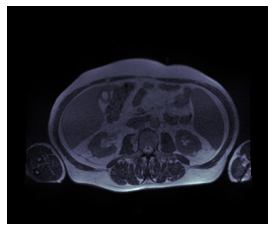

In [52]:
show_img(load_img(df[df["empty"]==False]["image_path"].iloc[500])[...,0])

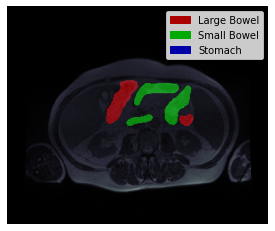

In [53]:
img = load_img(df[df["empty"]==False]["image_path"].iloc[500])[...,0]
mask = load_msk(df[df["empty"]==False]["mask_path"].iloc[500])
show_img(img, mask)

In [55]:
skf = StratifiedGroupKFold(n_splits=CFG["n_fold"], shuffle=True, random_state=CFG["seed"])
for fold, (train_idx, val_idx) in enumerate(skf.split(df, df['empty'], groups = df["case"])):
    df.loc[val_idx, 'fold'] = fold

In [56]:
display(df.groupby(['fold','empty'])['id'].count())

fold  empty
0.0   False    3164
      True     3892
1.0   False    3772
      True     5236
2.0   False    2931
      True     3853
3.0   False    3460
      True     4332
4.0   False    3166
      True     4402
Name: id, dtype: int64

In [57]:
display(df.groupby(['case','fold'])['id'].count())

case  fold
2     0.0     720
6     3.0     432
7     2.0     288
9     0.0     432
11    3.0     432
             ... 
147   1.0     720
148   2.0     288
149   0.0     432
154   3.0     720
156   1.0     432
Name: id, Length: 85, dtype: int64

In [58]:
class BuildDataset(torch.utils.data.Dataset):
    def __init__(self, df, training_mode=True, transforms=None):
        self.df         = df
        self.training_mode      = training_mode
        self.img_paths  = df['image_path'].tolist()
        self.msk_paths  = df['mask_path'].tolist()
        self.transforms = transforms
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        img_path  = self.img_paths[index]
        img = []
        img = load_img(img_path)
        
        if self.training_mode:
            msk_path = self.msk_paths[index]
            msk = load_msk(msk_path)
            if self.transforms:
                data = self.transforms(image=img, mask=msk)
                img  = data['image']
                msk  = data['mask']
            img = np.transpose(img, (2, 0, 1))
            msk = np.transpose(msk, (2, 0, 1))
            return torch.tensor(img), torch.tensor(msk)
        else:
            if self.transforms:
                data = self.transforms(image=img)
                img  = data['image']
            img = np.transpose(img, (2, 0, 1))
            return torch.tensor(img)

In [59]:
data_transforms = {
    "train": A.Compose([
        A.Resize(*CFG["img_size"], interpolation=cv2.INTER_NEAREST),
        #A.HorizontalFlip(p=0.5),
        #A.VerticalFlip(p=0.5),
        #A.RandomRotate90(p=0.5),

        #A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.05, rotate_limit=10, p=0.5),
        #A.OpticalDistortion(distort_limit=0.05, shift_limit=0.05, p=0.5),
        #A.GridDistortion(num_steps=5, distort_limit=0.03, p=0.5),
        #A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=0.5),
        #A.OneOf([
        #    A.GridDistortion(num_steps=5, distort_limit=0.05, p=1.0),
        #    A.OpticalDistortion(distort_limit=0.05, shift_limit=0.05, p=1.0),
        #    A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=1.0)
        #], p=0.25),

        #A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=1),#20,30,20 ランダムに色相、彩度、輝度を変える
        #A.RandomGamma(gamma_limit=(60, 140), p=1),#80, 120 ランダムにガンマ変換をかける
        #A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=1),#0.2, 0.2, ランダムに明るさとコントラストを変える

        #A.OpticalDistortion(distort_limit=0.5, shift_limit=0.5, p=1),#0.05 0.05 光学的な歪みを再現する
        #A.GaussNoise(var_limit=(10.0, 200.0), p=1.0),#10.0 50.0
        #A.MotionBlur(blur_limit=(3, 7), p=1.0),#3 7

        #A.CoarseDropout(max_holes=8, max_height=CFG["img_size"][0]//20, max_width=CFG["img_size"][1]//20,
        #                 min_holes=5, fill_value=0, mask_fill_value=0, p=0.5),
        ], p=1.0),
    
    "valid": A.Compose([
        A.Resize(*CFG["img_size"], interpolation=cv2.INTER_NEAREST),
        ], p=1.0)
}

In [60]:
data_transforms_dict = {}
for transform in data_transforms["train"]:
    s = str(transform)
    data_transforms_dict["A_"+s[:s.find("(")]] = s[s.find("(")+1:-1]

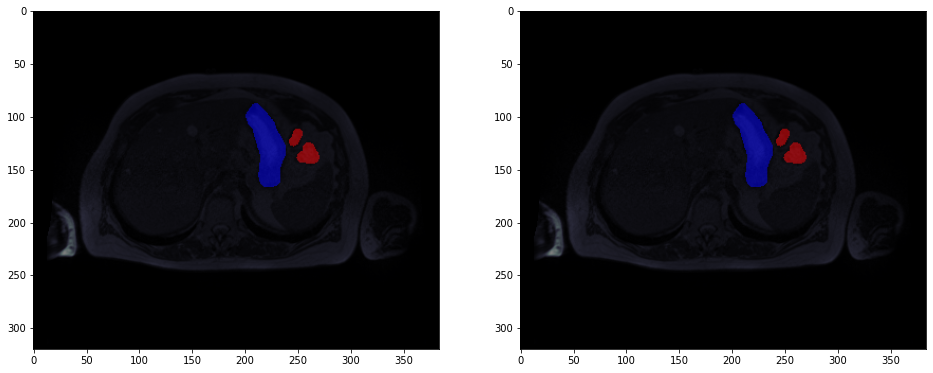

In [61]:
ids = random.randint(0,len(df[df["empty"]==False]))

img = load_img(df[df["empty"]==False]["image_path"].iloc[ids])
#img = Image.open(df[df["empty"]==False]["image_path"].iloc[ids])
mask = load_msk(df[df["empty"]==False]["mask_path"].iloc[ids])
#mask = Image.open(df[df["empty"]==False]["mask_path_png"].iloc[ids])

transforms = A.Compose(data_transforms["train"])(image=img, mask=mask)
#mask_transforms = A.Compose(data_transforms["train"])(image=mask)['image']

fig = plt.figure(figsize=(16,18))
ax1 = fig.add_subplot(1, 2, 1)
ax1.imshow(img[...,0], cmap='bone')
ax1.imshow(mask, alpha=0.5)
ax2 = fig.add_subplot(1, 2, 2)
ax2.imshow(transforms["image"][...,0], cmap='bone')
ax2.imshow(transforms["mask"], alpha=0.5)
plt.show()

In [62]:
def prepare_loaders(fold, debug=False):
    train_df = df.query("fold!=@fold").reset_index(drop=True)
    valid_df = df.query("fold==@fold").reset_index(drop=True)
    if debug:
        train_df = train_df.query("empty==0").head(8)
        valid_df = valid_df.query("empty==0").head(8)
    train_dataset = BuildDataset(train_df, transforms=data_transforms['train'])
    valid_dataset = BuildDataset(valid_df, transforms=data_transforms['valid'])

    train_loader = DataLoader(train_dataset, batch_size=CFG["train_bs"] if not debug else 8, 
                              num_workers=os.cpu_count(), shuffle=True, pin_memory=True, drop_last=False)
    valid_loader = DataLoader(valid_dataset, batch_size=CFG["valid_bs"] if not debug else 8, 
                              num_workers=os.cpu_count(), shuffle=False, pin_memory=True)
    
    return train_loader, valid_loader

In [63]:
train_loader, valid_loader = prepare_loaders(fold=0, debug=True)

In [64]:
imgs, msks = next(iter(train_loader))
imgs.size(), msks.size()

(torch.Size([8, 5, 320, 384]), torch.Size([8, 3, 320, 384]))

In [65]:
def plot_batch(imgs, msks, size=3):
    num_images = min(size, len(imgs), 15)
    plt.figure(figsize=(10*((num_images//3)+1), 10*3))
    #for idx in range(size):
    for idx in range(num_images):
        plt.subplot((num_images//3)+1, 3, idx+1)
        img = imgs[idx,].permute((1, 2, 0)).numpy()*255.0
        img = img.astype('uint8')
        msk = msks[idx,].permute((1, 2, 0)).numpy()*255.0
        msk = msk.astype('uint8')
        show_img_with_mask(img, msk)
    plt.tight_layout()
    plt.show()

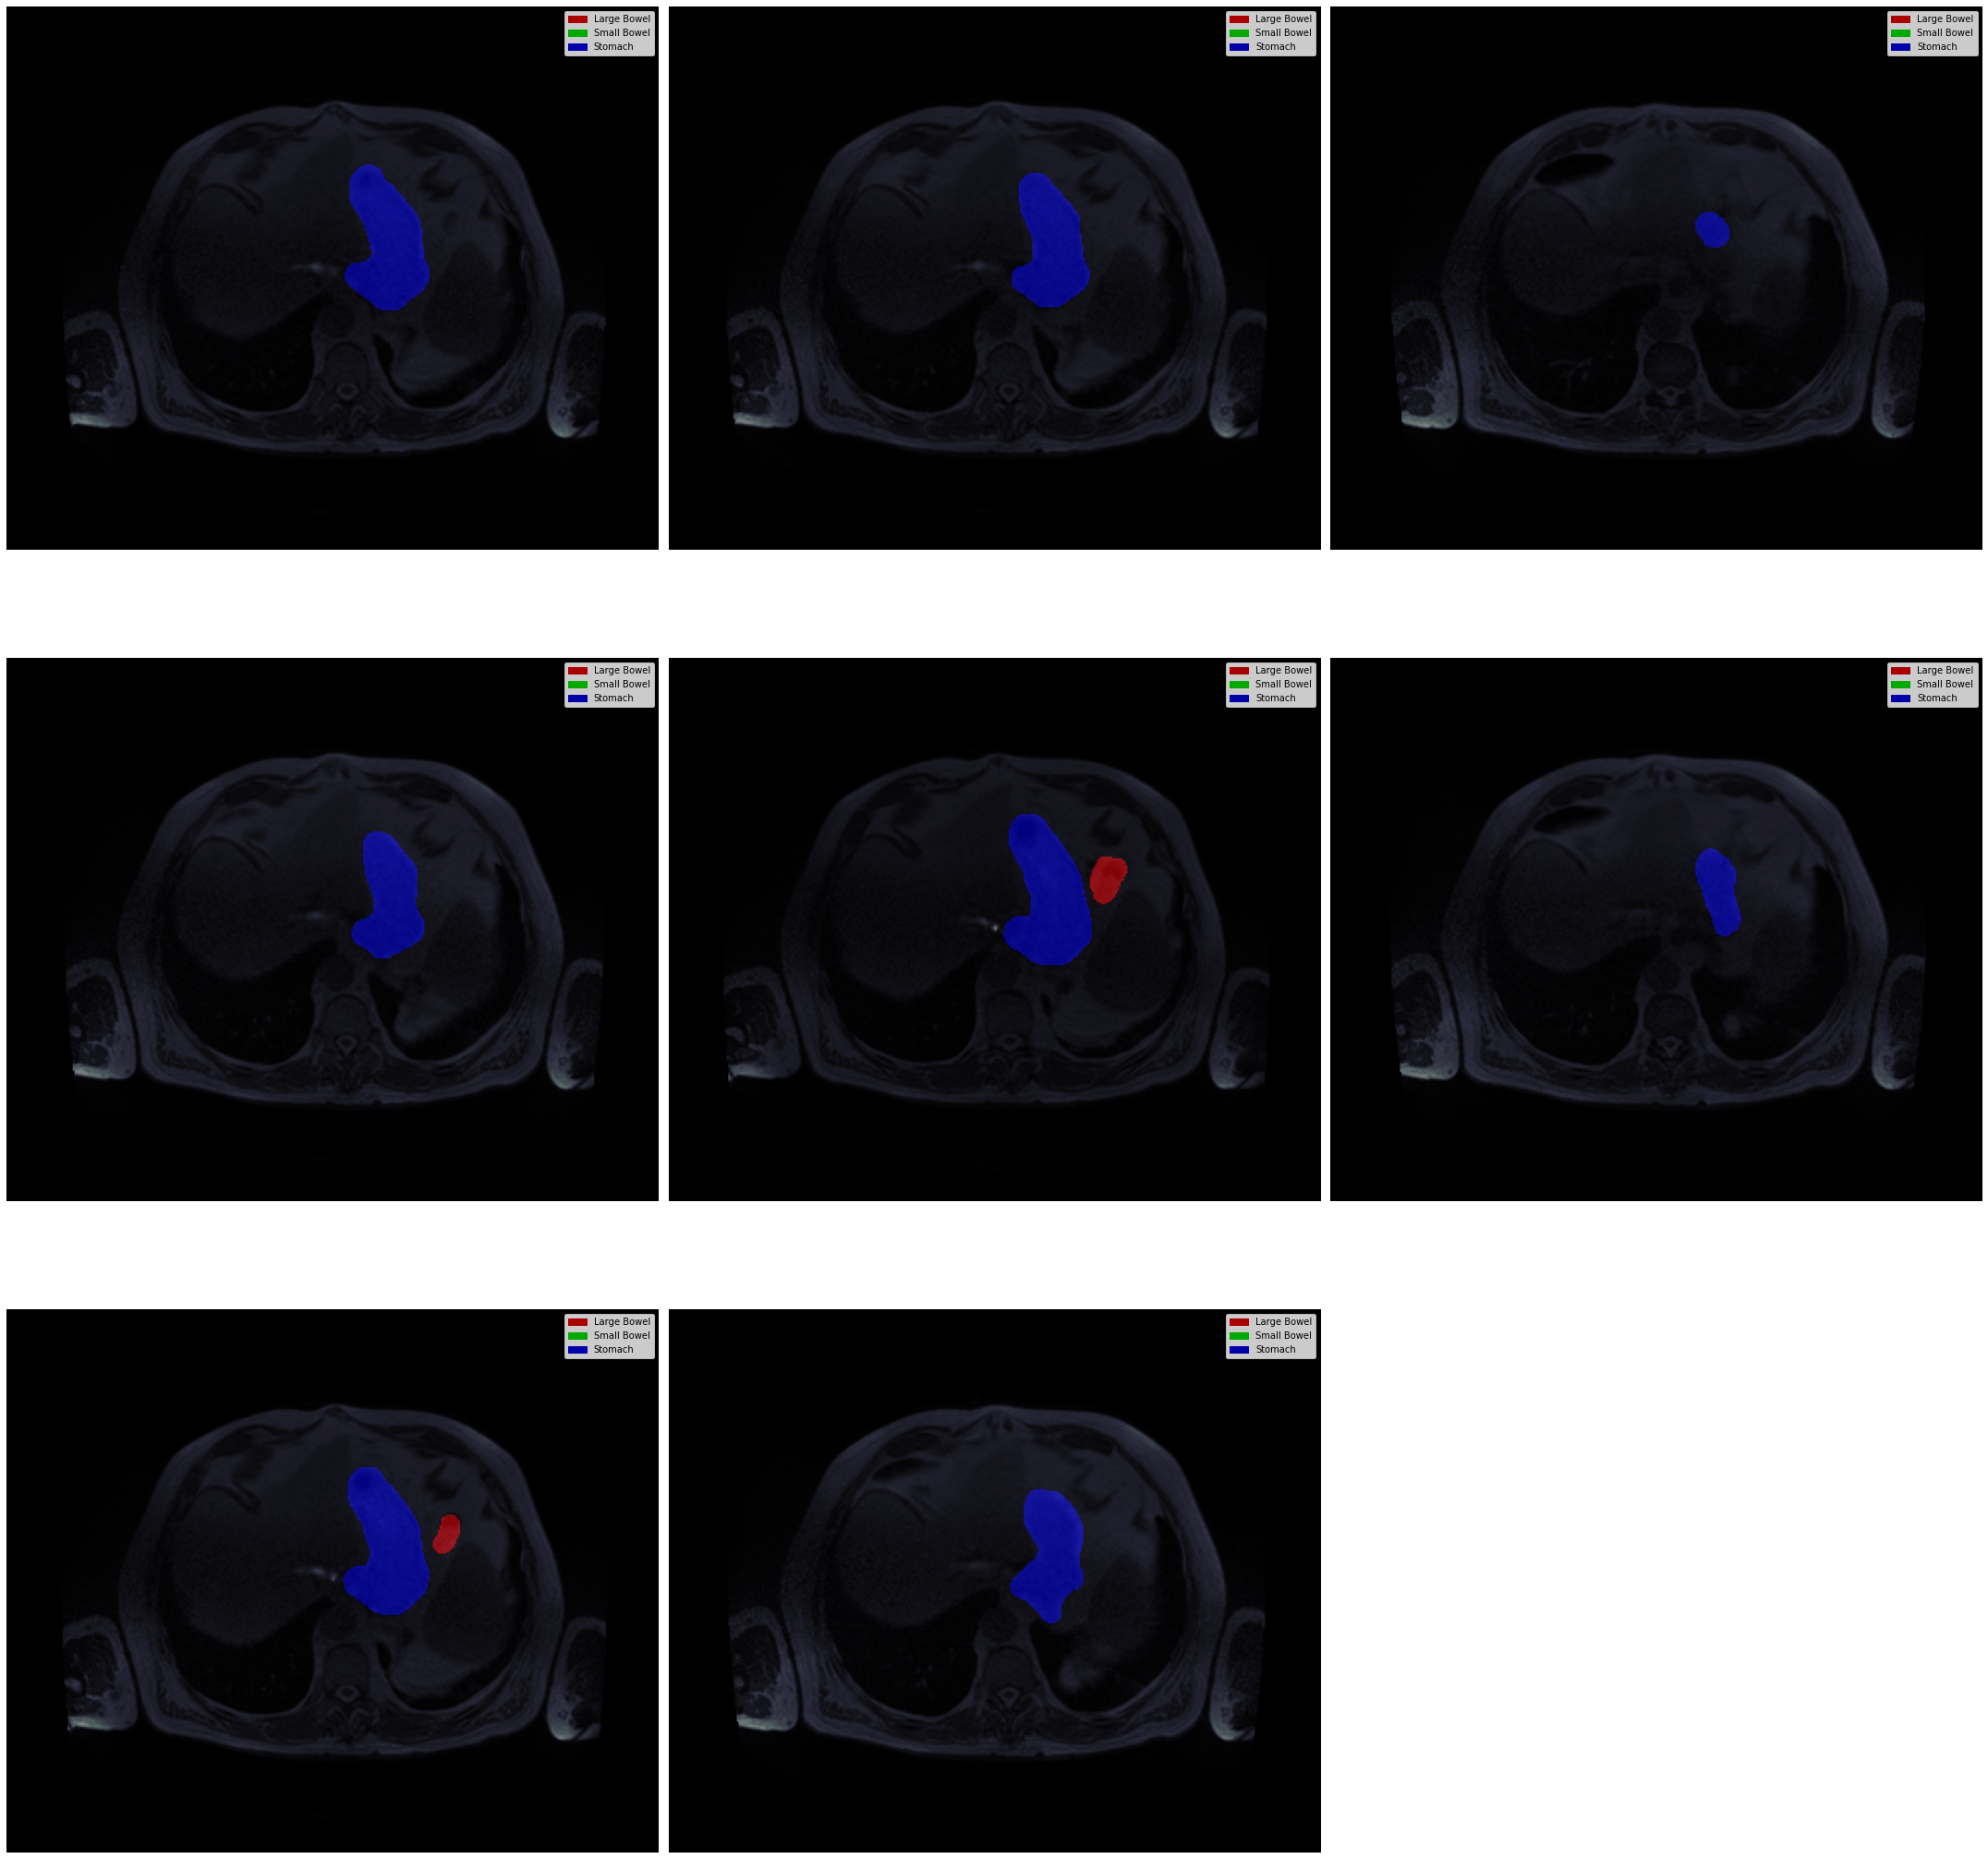

In [66]:
plot_batch(imgs, msks, size=15)

**---------- Model ----------**

In [67]:
import segmentation_models_pytorch as smp

def build_model():
    model = smp.UnetPlusPlus(#UnetPlusPlus
        encoder_name=CFG["backbone"],      # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
        #encoder_weights="noisy-student",     # use `imagenet` pre-trained weights for encoder initialization
        encoder_weights=CFG["encoder_weights"],
        #in_channels=7,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
        in_channels=CFG["in_channels"],
        classes=CFG["num_classes"],        # model output channels (number of classes in your dataset)
        activation=None,
    )
    model.to(CFG["device"])
    return model

def load_model(path):
    model = build_model()
    model.load_state_dict(torch.load(path))
    model.eval()
    return model

In [68]:
from scipy.spatial.distance import directed_hausdorff
#from hausdorff import hausdorff_distance
from monai.metrics.utils import get_mask_edges, get_surface_distance

JaccardLoss = smp.losses.JaccardLoss(mode='multilabel')
DiceLoss    = smp.losses.DiceLoss(mode='multilabel')
BCELoss     = smp.losses.SoftBCEWithLogitsLoss()
LovaszLoss  = smp.losses.LovaszLoss(mode='multilabel', per_image=False)
TverskyLoss = smp.losses.TverskyLoss(mode='multilabel', log_loss=False)
FocalLoss = smp.losses.FocalLoss(mode="multilabel")

def dice_coef(y_true, y_pred, thr=0.5, dim=(2,3), epsilon=0.001):
    y_true = y_true.to(torch.float32)
    y_pred = (y_pred>thr).to(torch.float32)
    inter = (y_true*y_pred).sum(dim=dim)
    den = y_true.sum(dim=dim) + y_pred.sum(dim=dim)
    dice = ((2*inter+epsilon)/(den+epsilon)).mean(dim=(1,0))
    return dice

def iou_coef(y_true, y_pred, thr=0.5, dim=(2,3), epsilon=0.001):
    y_true = y_true.to(torch.float32)
    y_pred = (y_pred>thr).to(torch.float32)
    inter = (y_true*y_pred).sum(dim=dim)
    union = (y_true + y_pred - y_true*y_pred).sum(dim=dim)
    iou = ((inter+epsilon)/(union+epsilon)).mean(dim=(1,0))
    return iou

#Hausdorff distance
def hausdorff_dist(y_true, y_pred):
    y_true = np.argwhere(y_true.cpu().detach().numpy())
    y_pred = np.argwhere(y_pred.cpu().detach().numpy())
    dist = max(directed_hausdorff(y_true, y_pred)[0], directed_hausdorff(y_pred, y_true)[0])
    #dist = max(hausdorff_distance(y_true, y_pred, distance='cosine'), hausdorff_distance(y_pred, y_true, distance='cosine'))
    return dist

def hausdorff_coef(gt, pred):
    max_dist = math.sqrt((CFG["img_size"][0]-1)**2 + (CFG["img_size"][1]-1)**2)
    gt = gt.cpu().detach().numpy()
    pred = pred.cpu().detach().numpy()
    if np.all(pred == gt):
        return 1.0#0.0
    (edges_pred, edges_gt) = get_mask_edges(pred, gt)
    surface_distance = get_surface_distance(edges_pred, edges_gt, distance_metric="euclidean")
    if surface_distance.shape == (0,):
        return 1.0#0.0
    dist = surface_distance.max()
    if dist > max_dist:
        return 0.0#1.0
    return 1 - (dist / max_dist)#dist / max_dist

def criterion(y_pred, y_true):
    return 0.5*BCELoss(y_pred, y_true) + 0.5*TverskyLoss(y_pred, y_true)
    #return 0.5*BCELoss(y_pred, y_true) + 0.5*FocalLoss(y_pred, y_true)

    #FocalTverskyLoss
    #gamma=1.0
    #return (1 - TverskyLoss(y_pred, y_true))**gamma

#def criterion(y_pred, y_true):
#    return 0.5*BCELoss(y_pred, y_true) + 0.5*TverskyLoss(y_pred, y_true)

In [69]:
#Hausdorff distance
np_a = np.zeros((3, 224 ,224)) 
np_b = np.zeros((3, 224 ,224)) 
np_a[2,0,0] = 1.0
np_b[2,223,223] = 1.0
a = torch.from_numpy(np_a.astype(np.float32)).clone()
b = torch.from_numpy(np_b.astype(np.float32)).clone()

**---------- Learning ----------**

In [70]:
import gc
gc.collect()

218

In [72]:
from timm.scheduler import CosineLRScheduler
def fetch_scheduler(optimizer):
    if CFG["scheduler"] == 'CosineAnnealingLR':
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer,T_max=CFG["T_max"], 
                                                   eta_min=CFG["min_lr"])
    elif CFG["scheduler"] == 'CosineAnnealingWarmRestarts':
        scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer,T_0=CFG["T_0"], 
                                                             eta_min=CFG["min_lr"])
    elif CFG["scheduler"] == 'ReduceLROnPlateau':
        scheduler = lr_scheduler.ReduceLROnPlateau(optimizer,
                                                   mode='min',
                                                   factor=0.1,
                                                   patience=7,
                                                   threshold=0.0001,
                                                   min_lr=CFG["min_lr"],)
    elif CFG["scheduler"] == 'ExponentialLR':
        scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.85)
    elif CFG["scheduler"] == 'CosineLRScheduler':
        scheduler = CosineLRScheduler(optimizer, t_initial=CFG["epochs"], lr_min=1e-4, 
                                      warmup_t=round(CFG["epochs"]*0.2), warmup_lr_init=5e-5, warmup_prefix=True)
    elif CFG["scheduler"] == None:
        return None
        
    return scheduler

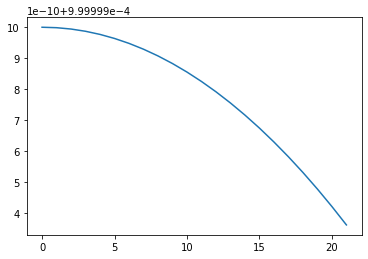

In [73]:
model = torch.nn.Linear(1, 1) ## 適当なモデル
optimizer = torch.optim.Adam(model.parameters())

scheduler = fetch_scheduler(optimizer)

lrs = []
for i in range(CFG["epochs"]):
    #lrs.append(scheduler.get_epoch_values(i))
    lrs.append(optimizer.param_groups[0]['lr'])
    if CFG["scheduler"] == 'CosineLRScheduler':
        scheduler.step(i+1)
    else:
        scheduler.step()

plt.plot(lrs)
plt.show()

In [74]:
def train_one_epoch(model, optimizer, scheduler, dataloader, device, epoch):
    model.train()
    scaler = amp.GradScaler()
    
    dataset_size = 0
    running_loss = 0.0
    
    pbar = tqdm(enumerate(dataloader), total=len(dataloader), desc='Train ')
    for step, (images, masks) in pbar:         
        images = images.to(device, dtype=torch.float)
        masks  = masks.to(device, dtype=torch.float)
        
        batch_size = images.size(0)
        
        with amp.autocast(enabled=True):
            y_pred = model(images)
            loss   = criterion(y_pred, masks)
            loss   = loss / CFG["n_accumulate"]
            
        scaler.scale(loss).backward()
    
        if (step + 1) % CFG["n_accumulate"] == 0:
            scaler.step(optimizer)
            scaler.update()

            # zero the parameter gradients
            optimizer.zero_grad()

            if scheduler is not None:
                if CFG["scheduler"] == 'CosineLRScheduler':
                    pass
                else:
                    scheduler.step()
                
        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        
        mem = torch.cuda.memory_reserved() / 1E9 if torch.cuda.is_available() else 0
        current_lr = optimizer.param_groups[0]['lr']
        pbar.set_postfix(train_loss=f'{epoch_loss:0.4f}',
                        lr=f'{current_lr:0.5f}',
                        gpu_mem=f'{mem:0.2f} GB')
    torch.cuda.empty_cache()
    gc.collect()
    
    return epoch_loss

In [75]:
@torch.no_grad()
def valid_one_epoch(model, dataloader, device, epoch):
    model.eval()
    
    dataset_size = 0
    running_loss = 0.0
    
    val_scores = []
    
    pbar = tqdm(enumerate(dataloader), total=len(dataloader), desc='Valid ')
    for step, (images, masks) in pbar:        
        images  = images.to(device, dtype=torch.float)
        masks   = masks.to(device, dtype=torch.float)
        
        batch_size = images.size(0)
        
        y_pred  = model(images)
        loss    = criterion(y_pred, masks)
        
        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        
        y_pred = nn.Sigmoid()(y_pred)
        val_dice = dice_coef(masks, y_pred).cpu().detach().numpy()
        val_jaccard = iou_coef(masks, y_pred).cpu().detach().numpy()
        val_hausdorff = hausdorff_coef(masks, y_pred)
        #val_hausdorff = 0
        val_scores.append([val_dice, val_jaccard, val_hausdorff])
        
        mem = torch.cuda.memory_reserved() / 1E9 if torch.cuda.is_available() else 0
        current_lr = optimizer.param_groups[0]['lr']
        pbar.set_postfix(valid_loss=f'{epoch_loss:0.4f}',
                        lr=f'{current_lr:0.5f}',
                        gpu_memory=f'{mem:0.2f} GB')
    val_scores  = np.mean(val_scores, axis=0)
    torch.cuda.empty_cache()
    gc.collect()
    
    return epoch_loss, val_scores

In [76]:
def run_training(model, optimizer, scheduler, device, num_epochs):
    # To automatically log gradients
    wandb.watch(model, log_freq=100)
    
    start = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_dice      = -np.inf
    best_epoch     = -1
    history = defaultdict(list)
    
    for epoch in range(1, num_epochs + 1): 
        gc.collect()
        print(f'Epoch {epoch}/{num_epochs}', end='\n')
        #print()
        train_loss = train_one_epoch(model, optimizer, scheduler, 
                                           dataloader=train_loader, 
                                           device=CFG["device"], epoch=epoch)
        
        val_loss, val_scores = valid_one_epoch(model, valid_loader, 
                                                 device=CFG["device"], 
                                                 epoch=epoch)
        val_dice, val_jaccard, val_hausdorff = val_scores
    
        history['Train Loss'].append(train_loss)
        history['Valid Loss'].append(val_loss)
        history['Valid Dice'].append(val_dice)
        history['Valid Jaccard'].append(val_jaccard)
        history['Valid Hausdorff'].append(val_hausdorff)
        
        # Log the metrics
        wandb.log({"Train Loss": train_loss, 
                   "Valid Loss": val_loss,
                   "Valid Dice": val_dice,
                   "Valid Jaccard": val_jaccard,
                   "Valid Hausdorff": val_hausdorff,
                   "LR":optimizer.param_groups[0]['lr']})
                   #"LR":scheduler.get_last_lr()[0]})
        
        print(f"{b_}Valid Dice: {val_dice:0.4f} | Valid Jaccard: {val_jaccard:0.4f} | Valid Hausdorff: {val_hausdorff:0.4f}{sr_}")
        
        # deep copy the model
        if val_dice >= best_dice:
            print(f"{r_}Valid Score Improved ({best_dice:0.4f} ---> {val_dice:0.4f})")
            best_dice    = val_dice
            best_jaccard = val_jaccard
            best_hausdorff = val_hausdorff
            best_epoch   = epoch
            run.summary["Best Dice"]    = best_dice
            run.summary["Best Jaccard"] = best_jaccard
            run.summary["Best Hausdorff"] = best_hausdorff
            run.summary["Best Epoch"]   = best_epoch
            best_model_wts = copy.deepcopy(model.state_dict())
            #PATH = f"best_epoch-{fold:02d}.bin"
            PATH = f"/content/OUTPUT/MODEL/best_epoch-{fold:02d}.bin"
            torch.save(model.state_dict(), PATH)
            # Save a model file from the current directory
            wandb.save(PATH, base_path="/content/OUTPUT/MODEL")
            print(f"Model Saved{sr_}")

        if CFG["scheduler"] == 'CosineLRScheduler':
            scheduler.step(epoch+1)
            
        last_model_wts = copy.deepcopy(model.state_dict())
        #PATH = f"last_epoch-{fold:02d}.bin"
        PATH = f"/content/OUTPUT/MODEL/last_epoch-{fold:02d}.bin"
        torch.save(model.state_dict(), PATH)
            
        print()

    with open("/content/OUTPUT/CFG.pickle", 'wb') as f:
        pickle.dump(CFG, f)
    wandb.save("/content/OUTPUT/CFG.pickle")
    
    end = time.time()
    time_elapsed = end - start
    print('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(
        time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))
    print("Best Score: {:.4f}".format(best_jaccard))
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    
    return model, history

In [77]:
model = build_model()
optimizer = optim.Adam(model.parameters(), lr=CFG["lr"], weight_decay=CFG["wd"])
scheduler = fetch_scheduler(optimizer)

In [81]:
if torch.cuda.is_available():
    print("cuda: {}\n".format(torch.cuda.get_device_name()))

#config = {k:v for k, v in dict(vars(CFG)).items() if '__' not in k}
#config.update(data_transforms_dict)
CFG.update(data_transforms_dict)

#n_fold = 1 if CFG["debug"] else CFG["n_fold"]
n_fold = CFG["n_fold"]#1

for fold in range(n_fold):
    print(f'#'*15)
    print(f'### Fold: {fold}')
    print(f'#'*15)
    run = wandb.init(project='UW-Madison_GI_Tract_Image_Segmentation', 
                     group=run_start_time,
                     name=f"fold-{fold}",
                     config=CFG,
                     #anonymous=anonymous,
                     tags=CFG["tags"],
                    )
    train_loader, valid_loader = prepare_loaders(fold=fold, debug=CFG["debug"])
    model     = build_model()
    optimizer = optim.Adam(model.parameters(), lr=CFG["lr"], weight_decay=CFG["wd"])
    scheduler = fetch_scheduler(optimizer)
    model, history = run_training(model, optimizer, scheduler,
                                  device=CFG["device"],
                                  num_epochs=CFG["epochs"])
    #run.finish()
    display(ipd.IFrame(run.url, width=1000, height=720))

cuda: Tesla V100-SXM2-16GB

###############
### Fold: 0
###############


Epoch 1/22


Valid : 100%|██████████| 1/1 [00:00<00:00,  2.87it/s, gpu_memory=1.04 GB, lr=0.00200, valid_loss=0.6703]


Valid Dice: 0.0083 | Valid Jaccard: 0.0042 | Valid Hausdorff: 0.0000
Valid Score Improved (-inf ---> 0.0083)
Model Saved

Epoch 2/22


Valid : 100%|██████████| 1/1 [00:00<00:00,  2.90it/s, gpu_memory=1.07 GB, lr=0.00200, valid_loss=0.5774]


Valid Dice: 0.0083 | Valid Jaccard: 0.0042 | Valid Hausdorff: 0.0000
Valid Score Improved (0.0083 ---> 0.0083)
Model Saved

Epoch 3/22


Valid : 100%|██████████| 1/1 [00:00<00:00,  3.02it/s, gpu_memory=1.08 GB, lr=0.00200, valid_loss=0.5381]


Valid Dice: 0.0083 | Valid Jaccard: 0.0042 | Valid Hausdorff: 0.0000
Valid Score Improved (0.0083 ---> 0.0083)
Model Saved

Epoch 4/22


Valid : 100%|██████████| 1/1 [00:00<00:00,  2.58it/s, gpu_memory=1.09 GB, lr=0.00200, valid_loss=0.5178]


Valid Dice: 0.0084 | Valid Jaccard: 0.0042 | Valid Hausdorff: 0.0000
Valid Score Improved (0.0083 ---> 0.0084)
Model Saved

Epoch 5/22


Valid : 100%|██████████| 1/1 [00:00<00:00,  2.93it/s, gpu_memory=1.08 GB, lr=0.00200, valid_loss=0.5047]


Valid Dice: 0.0084 | Valid Jaccard: 0.0042 | Valid Hausdorff: 0.0000

Epoch 6/22


Valid : 100%|██████████| 1/1 [00:00<00:00,  2.94it/s, gpu_memory=1.09 GB, lr=0.00200, valid_loss=0.4997]


Valid Dice: 0.0083 | Valid Jaccard: 0.0042 | Valid Hausdorff: 0.0000

Epoch 7/22


Valid : 100%|██████████| 1/1 [00:00<00:00,  3.00it/s, gpu_memory=1.08 GB, lr=0.00200, valid_loss=0.5064]


Valid Dice: 0.0082 | Valid Jaccard: 0.0042 | Valid Hausdorff: 0.0000

Epoch 8/22


Valid : 100%|██████████| 1/1 [00:00<00:00,  2.88it/s, gpu_memory=1.09 GB, lr=0.00200, valid_loss=0.5216]


Valid Dice: 0.0079 | Valid Jaccard: 0.0040 | Valid Hausdorff: 0.0000

Epoch 9/22


Valid : 100%|██████████| 1/1 [00:00<00:00,  2.86it/s, gpu_memory=1.09 GB, lr=0.00200, valid_loss=0.5317]


Valid Dice: 0.0076 | Valid Jaccard: 0.0039 | Valid Hausdorff: 0.0000

Epoch 10/22


Valid : 100%|██████████| 1/1 [00:00<00:00,  2.96it/s, gpu_memory=1.09 GB, lr=0.00200, valid_loss=0.5398]


Valid Dice: 0.0074 | Valid Jaccard: 0.0037 | Valid Hausdorff: 0.0000

Epoch 11/22


Valid : 100%|██████████| 1/1 [00:00<00:00,  2.94it/s, gpu_memory=1.09 GB, lr=0.00200, valid_loss=0.5451]


Valid Dice: 0.0072 | Valid Jaccard: 0.0036 | Valid Hausdorff: 0.0000

Epoch 12/22


Valid : 100%|██████████| 1/1 [00:00<00:00,  3.03it/s, gpu_memory=1.09 GB, lr=0.00200, valid_loss=0.5474]


Valid Dice: 0.0070 | Valid Jaccard: 0.0036 | Valid Hausdorff: 0.0000

Epoch 13/22


Valid : 100%|██████████| 1/1 [00:00<00:00,  3.01it/s, gpu_memory=1.09 GB, lr=0.00200, valid_loss=0.5487]


Valid Dice: 0.0069 | Valid Jaccard: 0.0035 | Valid Hausdorff: 0.0000

Epoch 14/22


Valid : 100%|██████████| 1/1 [00:00<00:00,  2.82it/s, gpu_memory=1.09 GB, lr=0.00200, valid_loss=0.5471]


Valid Dice: 0.0069 | Valid Jaccard: 0.0035 | Valid Hausdorff: 0.0000

Epoch 15/22


Valid : 100%|██████████| 1/1 [00:00<00:00,  3.05it/s, gpu_memory=1.09 GB, lr=0.00200, valid_loss=0.5448]


Valid Dice: 0.0068 | Valid Jaccard: 0.0035 | Valid Hausdorff: 0.0000

Epoch 16/22


Valid : 100%|██████████| 1/1 [00:00<00:00,  3.03it/s, gpu_memory=1.09 GB, lr=0.00200, valid_loss=0.5428]


Valid Dice: 0.0068 | Valid Jaccard: 0.0035 | Valid Hausdorff: 0.0000

Epoch 17/22


Valid : 100%|██████████| 1/1 [00:00<00:00,  2.99it/s, gpu_memory=1.09 GB, lr=0.00200, valid_loss=0.5435]


Valid Dice: 0.0068 | Valid Jaccard: 0.0034 | Valid Hausdorff: 0.0000

Epoch 18/22


Valid : 100%|██████████| 1/1 [00:00<00:00,  2.95it/s, gpu_memory=1.09 GB, lr=0.00200, valid_loss=0.5448]


Valid Dice: 0.0068 | Valid Jaccard: 0.0035 | Valid Hausdorff: 0.0000

Epoch 19/22


Valid : 100%|██████████| 1/1 [00:00<00:00,  2.88it/s, gpu_memory=1.09 GB, lr=0.00200, valid_loss=0.5458]


Valid Dice: 0.0069 | Valid Jaccard: 0.0035 | Valid Hausdorff: 0.0000

Epoch 20/22


Valid : 100%|██████████| 1/1 [00:00<00:00,  2.78it/s, gpu_memory=1.09 GB, lr=0.00200, valid_loss=0.5465]


Valid Dice: 0.0069 | Valid Jaccard: 0.0035 | Valid Hausdorff: 0.0000

Epoch 21/22


Valid : 100%|██████████| 1/1 [00:00<00:00,  2.56it/s, gpu_memory=1.09 GB, lr=0.00200, valid_loss=0.5466]


Valid Dice: 0.0070 | Valid Jaccard: 0.0035 | Valid Hausdorff: 0.0000

Epoch 22/22


Valid : 100%|██████████| 1/1 [00:00<00:00,  2.87it/s, gpu_memory=1.09 GB, lr=0.00200, valid_loss=0.5466]
wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")


Valid Dice: 0.0070 | Valid Jaccard: 0.0036 | Valid Hausdorff: 0.0000

Training complete in 0h 0m 55s
Best Score: 0.0042


###############
### Fold: 1
###############


LR,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train Loss,▆▇▁▆▆▆▇█▆▆█▆▇█▇▇▇▄▇▆▆▇
Valid Dice,██████▇▆▅▄▃▂▂▁▁▁▁▁▁▁▂▂
Valid Hausdorff,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Valid Jaccard,██████▇▆▅▄▃▂▂▁▁▁▁▁▁▁▂▂
Valid Loss,█▄▃▂▁▁▁▂▂▃▃▃▃▃▃▃▃▃▃▃▃▃
Best Dice,0.00836
Best Epoch,4
Best Hausdorff,0.0
Best Jaccard,0.00425
LR,0.002


Epoch 1/22


Valid : 100%|██████████| 1/1 [00:00<00:00,  2.95it/s, gpu_memory=1.07 GB, lr=0.00200, valid_loss=0.5921]


Valid Dice: 0.0025 | Valid Jaccard: 0.0013 | Valid Hausdorff: 0.0000
Valid Score Improved (-inf ---> 0.0025)
Model Saved

Epoch 2/22


Valid : 100%|██████████| 1/1 [00:00<00:00,  2.73it/s, gpu_memory=1.08 GB, lr=0.00200, valid_loss=0.5969]


Valid Dice: 0.0029 | Valid Jaccard: 0.0015 | Valid Hausdorff: 0.0000
Valid Score Improved (0.0025 ---> 0.0029)
Model Saved

Epoch 3/22


Valid : 100%|██████████| 1/1 [00:00<00:00,  2.81it/s, gpu_memory=1.12 GB, lr=0.00200, valid_loss=0.6085]


Valid Dice: 0.0038 | Valid Jaccard: 0.0019 | Valid Hausdorff: 0.0000
Valid Score Improved (0.0029 ---> 0.0038)
Model Saved

Epoch 4/22


Valid : 100%|██████████| 1/1 [00:00<00:00,  2.84it/s, gpu_memory=0.98 GB, lr=0.00200, valid_loss=0.6196]


Valid Dice: 0.0054 | Valid Jaccard: 0.0027 | Valid Hausdorff: 0.0000
Valid Score Improved (0.0038 ---> 0.0054)
Model Saved

Epoch 5/22


Valid : 100%|██████████| 1/1 [00:00<00:00,  2.93it/s, gpu_memory=1.08 GB, lr=0.00200, valid_loss=0.6324]


Valid Dice: 0.0067 | Valid Jaccard: 0.0034 | Valid Hausdorff: 0.0000
Valid Score Improved (0.0054 ---> 0.0067)
Model Saved

Epoch 6/22


Valid : 100%|██████████| 1/1 [00:00<00:00,  2.77it/s, gpu_memory=1.12 GB, lr=0.00200, valid_loss=0.6445]


Valid Dice: 0.0086 | Valid Jaccard: 0.0043 | Valid Hausdorff: 0.0000
Valid Score Improved (0.0067 ---> 0.0086)
Model Saved

Epoch 7/22


Valid : 100%|██████████| 1/1 [00:00<00:00,  2.74it/s, gpu_memory=0.98 GB, lr=0.00200, valid_loss=0.6563]


Valid Dice: 0.0091 | Valid Jaccard: 0.0046 | Valid Hausdorff: 0.0000
Valid Score Improved (0.0086 ---> 0.0091)
Model Saved

Epoch 8/22


Valid : 100%|██████████| 1/1 [00:00<00:00,  2.88it/s, gpu_memory=1.09 GB, lr=0.00200, valid_loss=0.6685]


Valid Dice: 0.0095 | Valid Jaccard: 0.0048 | Valid Hausdorff: 0.0000
Valid Score Improved (0.0091 ---> 0.0095)
Model Saved

Epoch 9/22


Valid : 100%|██████████| 1/1 [00:00<00:00,  2.69it/s, gpu_memory=1.12 GB, lr=0.00200, valid_loss=0.6844]


Valid Dice: 0.0103 | Valid Jaccard: 0.0053 | Valid Hausdorff: 0.0000
Valid Score Improved (0.0095 ---> 0.0103)
Model Saved

Epoch 10/22


Valid : 100%|██████████| 1/1 [00:00<00:00,  2.90it/s, gpu_memory=0.98 GB, lr=0.00200, valid_loss=0.7026]


Valid Dice: 0.0111 | Valid Jaccard: 0.0056 | Valid Hausdorff: 0.0000
Valid Score Improved (0.0103 ---> 0.0111)
Model Saved

Epoch 11/22


Valid : 100%|██████████| 1/1 [00:00<00:00,  2.85it/s, gpu_memory=1.09 GB, lr=0.00200, valid_loss=0.7168]


Valid Dice: 0.0114 | Valid Jaccard: 0.0058 | Valid Hausdorff: 0.0000
Valid Score Improved (0.0111 ---> 0.0114)
Model Saved

Epoch 12/22


Valid : 100%|██████████| 1/1 [00:00<00:00,  2.90it/s, gpu_memory=1.12 GB, lr=0.00200, valid_loss=0.7270]


Valid Dice: 0.0115 | Valid Jaccard: 0.0059 | Valid Hausdorff: 0.0000
Valid Score Improved (0.0114 ---> 0.0115)
Model Saved

Epoch 13/22


Valid : 100%|██████████| 1/1 [00:00<00:00,  2.96it/s, gpu_memory=0.98 GB, lr=0.00200, valid_loss=0.7329]


Valid Dice: 0.0116 | Valid Jaccard: 0.0059 | Valid Hausdorff: 0.0000
Valid Score Improved (0.0115 ---> 0.0116)
Model Saved

Epoch 14/22


Valid : 100%|██████████| 1/1 [00:00<00:00,  2.88it/s, gpu_memory=1.09 GB, lr=0.00200, valid_loss=0.7331]


Valid Dice: 0.0117 | Valid Jaccard: 0.0060 | Valid Hausdorff: 0.0000
Valid Score Improved (0.0116 ---> 0.0117)
Model Saved

Epoch 15/22


Valid : 100%|██████████| 1/1 [00:00<00:00,  2.80it/s, gpu_memory=1.12 GB, lr=0.00200, valid_loss=0.7326]


Valid Dice: 0.0118 | Valid Jaccard: 0.0060 | Valid Hausdorff: 0.0000
Valid Score Improved (0.0117 ---> 0.0118)
Model Saved

Epoch 16/22


Valid : 100%|██████████| 1/1 [00:00<00:00,  2.93it/s, gpu_memory=0.98 GB, lr=0.00200, valid_loss=0.7331]


Valid Dice: 0.0119 | Valid Jaccard: 0.0060 | Valid Hausdorff: 0.0000
Valid Score Improved (0.0118 ---> 0.0119)
Model Saved

Epoch 17/22


Valid : 100%|██████████| 1/1 [00:00<00:00,  2.85it/s, gpu_memory=1.09 GB, lr=0.00200, valid_loss=0.7338]


Valid Dice: 0.0119 | Valid Jaccard: 0.0061 | Valid Hausdorff: 0.0000
Valid Score Improved (0.0119 ---> 0.0119)
Model Saved

Epoch 18/22


Valid : 100%|██████████| 1/1 [00:00<00:00,  2.85it/s, gpu_memory=1.12 GB, lr=0.00200, valid_loss=0.7342]


Valid Dice: 0.0118 | Valid Jaccard: 0.0060 | Valid Hausdorff: 0.0000

Epoch 19/22


Valid : 100%|██████████| 1/1 [00:00<00:00,  2.77it/s, gpu_memory=0.98 GB, lr=0.00200, valid_loss=0.7341]


Valid Dice: 0.0118 | Valid Jaccard: 0.0060 | Valid Hausdorff: 0.0000

Epoch 20/22


Valid : 100%|██████████| 1/1 [00:00<00:00,  3.01it/s, gpu_memory=0.97 GB, lr=0.00200, valid_loss=0.7345]


Valid Dice: 0.0118 | Valid Jaccard: 0.0060 | Valid Hausdorff: 0.0000

Epoch 21/22


Valid : 100%|██████████| 1/1 [00:00<00:00,  2.82it/s, gpu_memory=0.98 GB, lr=0.00200, valid_loss=0.7349]


Valid Dice: 0.0118 | Valid Jaccard: 0.0060 | Valid Hausdorff: 0.0000

Epoch 22/22


Valid : 100%|██████████| 1/1 [00:00<00:00,  2.93it/s, gpu_memory=0.97 GB, lr=0.00200, valid_loss=0.7350]
wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")


Valid Dice: 0.0118 | Valid Jaccard: 0.0060 | Valid Hausdorff: 0.0000

Training complete in 0h 0m 58s
Best Score: 0.0061


###############
### Fold: 2
###############


LR,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train Loss,▄██▄████▄██████████▁▄█
Valid Dice,▁▁▂▃▄▆▆▆▇▇████████████
Valid Hausdorff,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Valid Jaccard,▁▁▂▃▄▅▆▆▇▇████████████
Valid Loss,▁▁▂▂▃▄▄▅▆▆▇███████████
Best Dice,0.01188
Best Epoch,17
Best Hausdorff,0.0
Best Jaccard,0.00606
LR,0.002


Epoch 1/22


Valid : 100%|██████████| 1/1 [00:00<00:00,  2.91it/s, gpu_memory=0.96 GB, lr=0.00200, valid_loss=0.7537]


Valid Dice: 0.0107 | Valid Jaccard: 0.0054 | Valid Hausdorff: 0.0000
Valid Score Improved (-inf ---> 0.0107)
Model Saved

Epoch 2/22


Valid : 100%|██████████| 1/1 [00:00<00:00,  2.80it/s, gpu_memory=1.06 GB, lr=0.00200, valid_loss=0.6954]


Valid Dice: 0.0112 | Valid Jaccard: 0.0057 | Valid Hausdorff: 0.0000
Valid Score Improved (0.0107 ---> 0.0112)
Model Saved

Epoch 3/22


Valid : 100%|██████████| 1/1 [00:00<00:00,  2.83it/s, gpu_memory=1.08 GB, lr=0.00200, valid_loss=0.6851]


Valid Dice: 0.0112 | Valid Jaccard: 0.0057 | Valid Hausdorff: 0.0000
Valid Score Improved (0.0112 ---> 0.0112)
Model Saved

Epoch 4/22


Valid : 100%|██████████| 1/1 [00:00<00:00,  2.92it/s, gpu_memory=1.04 GB, lr=0.00200, valid_loss=0.6807]


Valid Dice: 0.0113 | Valid Jaccard: 0.0057 | Valid Hausdorff: 0.0000
Valid Score Improved (0.0112 ---> 0.0113)
Model Saved

Epoch 5/22


Valid : 100%|██████████| 1/1 [00:00<00:00,  2.64it/s, gpu_memory=1.07 GB, lr=0.00200, valid_loss=0.6809]


Valid Dice: 0.0109 | Valid Jaccard: 0.0055 | Valid Hausdorff: 0.0000

Epoch 6/22


Valid : 100%|██████████| 1/1 [00:00<00:00,  2.73it/s, gpu_memory=1.07 GB, lr=0.00200, valid_loss=0.6768]


Valid Dice: 0.0111 | Valid Jaccard: 0.0056 | Valid Hausdorff: 0.0000

Epoch 7/22


Valid : 100%|██████████| 1/1 [00:00<00:00,  2.95it/s, gpu_memory=1.07 GB, lr=0.00200, valid_loss=0.6680]


Valid Dice: 0.0112 | Valid Jaccard: 0.0057 | Valid Hausdorff: 0.0000

Epoch 8/22


Valid : 100%|██████████| 1/1 [00:00<00:00,  2.80it/s, gpu_memory=1.07 GB, lr=0.00200, valid_loss=0.6609]


Valid Dice: 0.0114 | Valid Jaccard: 0.0058 | Valid Hausdorff: 0.0000
Valid Score Improved (0.0113 ---> 0.0114)
Model Saved

Epoch 9/22


Valid : 100%|██████████| 1/1 [00:00<00:00,  2.82it/s, gpu_memory=1.08 GB, lr=0.00200, valid_loss=0.6552]


Valid Dice: 0.0112 | Valid Jaccard: 0.0057 | Valid Hausdorff: 0.0000

Epoch 10/22


Valid : 100%|██████████| 1/1 [00:00<00:00,  2.73it/s, gpu_memory=1.04 GB, lr=0.00200, valid_loss=0.6529]


Valid Dice: 0.0108 | Valid Jaccard: 0.0055 | Valid Hausdorff: 0.0000

Epoch 11/22


Valid : 100%|██████████| 1/1 [00:00<00:00,  2.88it/s, gpu_memory=1.08 GB, lr=0.00200, valid_loss=0.6514]


Valid Dice: 0.0104 | Valid Jaccard: 0.0053 | Valid Hausdorff: 0.0000

Epoch 12/22


Valid : 100%|██████████| 1/1 [00:00<00:00,  2.89it/s, gpu_memory=1.04 GB, lr=0.00200, valid_loss=0.6510]


Valid Dice: 0.0098 | Valid Jaccard: 0.0050 | Valid Hausdorff: 0.0000

Epoch 13/22


Valid : 100%|██████████| 1/1 [00:00<00:00,  2.92it/s, gpu_memory=1.08 GB, lr=0.00200, valid_loss=0.6517]


Valid Dice: 0.0095 | Valid Jaccard: 0.0048 | Valid Hausdorff: 0.0000

Epoch 14/22


Valid : 100%|██████████| 1/1 [00:00<00:00,  2.82it/s, gpu_memory=1.04 GB, lr=0.00200, valid_loss=0.6534]


Valid Dice: 0.0091 | Valid Jaccard: 0.0046 | Valid Hausdorff: 0.0000

Epoch 15/22


Valid : 100%|██████████| 1/1 [00:00<00:00,  2.86it/s, gpu_memory=1.08 GB, lr=0.00200, valid_loss=0.6553]


Valid Dice: 0.0088 | Valid Jaccard: 0.0044 | Valid Hausdorff: 0.0000

Epoch 16/22


Valid : 100%|██████████| 1/1 [00:00<00:00,  2.77it/s, gpu_memory=1.04 GB, lr=0.00200, valid_loss=0.6559]


Valid Dice: 0.0087 | Valid Jaccard: 0.0044 | Valid Hausdorff: 0.0000

Epoch 17/22


Valid : 100%|██████████| 1/1 [00:00<00:00,  2.77it/s, gpu_memory=1.08 GB, lr=0.00200, valid_loss=0.6552]


Valid Dice: 0.0085 | Valid Jaccard: 0.0043 | Valid Hausdorff: 0.0000

Epoch 18/22


Valid : 100%|██████████| 1/1 [00:00<00:00,  2.82it/s, gpu_memory=1.04 GB, lr=0.00200, valid_loss=0.6561]


Valid Dice: 0.0084 | Valid Jaccard: 0.0042 | Valid Hausdorff: 0.0000

Epoch 19/22


Valid : 100%|██████████| 1/1 [00:00<00:00,  2.55it/s, gpu_memory=1.08 GB, lr=0.00200, valid_loss=0.6569]


Valid Dice: 0.0094 | Valid Jaccard: 0.0048 | Valid Hausdorff: 0.0000

Epoch 20/22


Valid : 100%|██████████| 1/1 [00:00<00:00,  2.74it/s, gpu_memory=1.04 GB, lr=0.00200, valid_loss=0.6576]


Valid Dice: 0.0094 | Valid Jaccard: 0.0047 | Valid Hausdorff: 0.0000

Epoch 21/22


Valid : 100%|██████████| 1/1 [00:00<00:00,  2.93it/s, gpu_memory=1.08 GB, lr=0.00200, valid_loss=0.6587]


Valid Dice: 0.0086 | Valid Jaccard: 0.0043 | Valid Hausdorff: 0.0000

Epoch 22/22


Valid : 100%|██████████| 1/1 [00:00<00:00,  2.81it/s, gpu_memory=1.04 GB, lr=0.00200, valid_loss=0.6603]
wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")


Valid Dice: 0.0080 | Valid Jaccard: 0.0040 | Valid Hausdorff: 0.0000

Training complete in 0h 0m 57s
Best Score: 0.0058


###############
### Fold: 3
###############


LR,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train Loss,██▂▁▇█████▇█████▁███▂▇
Valid Dice,▆███▇▇███▇▆▅▄▃▃▂▂▂▄▄▂▁
Valid Hausdorff,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Valid Jaccard,▆███▇▇███▇▆▅▄▃▃▂▂▂▄▄▂▁
Valid Loss,█▄▃▃▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▂▂
Best Dice,0.01144
Best Epoch,8
Best Hausdorff,0.0
Best Jaccard,0.00579
LR,0.002


Epoch 1/22


Valid : 100%|██████████| 1/1 [00:00<00:00,  2.83it/s, gpu_memory=1.03 GB, lr=0.00200, valid_loss=0.6419]


Valid Dice: 0.0107 | Valid Jaccard: 0.0054 | Valid Hausdorff: 0.0000
Valid Score Improved (-inf ---> 0.0107)
Model Saved

Epoch 2/22


Valid : 100%|██████████| 1/1 [00:00<00:00,  2.85it/s, gpu_memory=1.07 GB, lr=0.00200, valid_loss=0.6356]


Valid Dice: 0.0100 | Valid Jaccard: 0.0051 | Valid Hausdorff: 0.0000

Epoch 3/22


Valid : 100%|██████████| 1/1 [00:00<00:00,  2.94it/s, gpu_memory=1.08 GB, lr=0.00200, valid_loss=0.6329]


Valid Dice: 0.0095 | Valid Jaccard: 0.0048 | Valid Hausdorff: 0.0000

Epoch 4/22


Valid : 100%|██████████| 1/1 [00:00<00:00,  2.83it/s, gpu_memory=1.08 GB, lr=0.00200, valid_loss=0.6312]


Valid Dice: 0.0140 | Valid Jaccard: 0.0071 | Valid Hausdorff: 0.0000
Valid Score Improved (0.0107 ---> 0.0140)
Model Saved

Epoch 5/22


Valid : 100%|██████████| 1/1 [00:00<00:00,  2.81it/s, gpu_memory=1.08 GB, lr=0.00200, valid_loss=0.6309]


Valid Dice: 0.0133 | Valid Jaccard: 0.0068 | Valid Hausdorff: 0.0000

Epoch 6/22


Valid : 100%|██████████| 1/1 [00:00<00:00,  2.89it/s, gpu_memory=1.08 GB, lr=0.00200, valid_loss=0.6333]


Valid Dice: 0.0107 | Valid Jaccard: 0.0054 | Valid Hausdorff: 0.0000

Epoch 7/22


Valid : 100%|██████████| 1/1 [00:00<00:00,  2.95it/s, gpu_memory=1.08 GB, lr=0.00200, valid_loss=0.6373]


Valid Dice: 0.0090 | Valid Jaccard: 0.0045 | Valid Hausdorff: 0.0000

Epoch 8/22


Valid : 100%|██████████| 1/1 [00:00<00:00,  2.81it/s, gpu_memory=1.08 GB, lr=0.00200, valid_loss=0.6429]


Valid Dice: 0.0071 | Valid Jaccard: 0.0036 | Valid Hausdorff: 0.0000

Epoch 9/22


Valid : 100%|██████████| 1/1 [00:00<00:00,  2.88it/s, gpu_memory=1.08 GB, lr=0.00200, valid_loss=0.6482]


Valid Dice: 0.0056 | Valid Jaccard: 0.0028 | Valid Hausdorff: 0.0000

Epoch 10/22


Valid : 100%|██████████| 1/1 [00:00<00:00,  2.83it/s, gpu_memory=1.08 GB, lr=0.00200, valid_loss=0.6538]


Valid Dice: 0.0044 | Valid Jaccard: 0.0022 | Valid Hausdorff: 0.0000

Epoch 11/22


Valid : 100%|██████████| 1/1 [00:00<00:00,  2.76it/s, gpu_memory=1.08 GB, lr=0.00200, valid_loss=0.6607]


Valid Dice: 0.0033 | Valid Jaccard: 0.0017 | Valid Hausdorff: 0.0000

Epoch 12/22


Valid : 100%|██████████| 1/1 [00:00<00:00,  2.84it/s, gpu_memory=1.08 GB, lr=0.00200, valid_loss=0.6686]


Valid Dice: 0.0024 | Valid Jaccard: 0.0012 | Valid Hausdorff: 0.0000

Epoch 13/22


Valid : 100%|██████████| 1/1 [00:00<00:00,  2.83it/s, gpu_memory=1.08 GB, lr=0.00200, valid_loss=0.6734]


Valid Dice: 0.0022 | Valid Jaccard: 0.0011 | Valid Hausdorff: 0.0000

Epoch 14/22


Valid : 100%|██████████| 1/1 [00:00<00:00,  2.97it/s, gpu_memory=1.08 GB, lr=0.00200, valid_loss=0.6768]


Valid Dice: 0.0021 | Valid Jaccard: 0.0011 | Valid Hausdorff: 0.0000

Epoch 15/22


Valid : 100%|██████████| 1/1 [00:00<00:00,  2.86it/s, gpu_memory=1.08 GB, lr=0.00200, valid_loss=0.6797]


Valid Dice: 0.0021 | Valid Jaccard: 0.0010 | Valid Hausdorff: 0.0000

Epoch 16/22


Valid : 100%|██████████| 1/1 [00:00<00:00,  2.85it/s, gpu_memory=1.08 GB, lr=0.00200, valid_loss=0.6815]


Valid Dice: 0.0022 | Valid Jaccard: 0.0011 | Valid Hausdorff: 0.0000

Epoch 17/22


Valid : 100%|██████████| 1/1 [00:00<00:00,  2.73it/s, gpu_memory=1.08 GB, lr=0.00200, valid_loss=0.6831]


Valid Dice: 0.0022 | Valid Jaccard: 0.0011 | Valid Hausdorff: 0.0000

Epoch 18/22


Valid : 100%|██████████| 1/1 [00:00<00:00,  2.85it/s, gpu_memory=1.08 GB, lr=0.00200, valid_loss=0.6846]


Valid Dice: 0.0023 | Valid Jaccard: 0.0011 | Valid Hausdorff: 0.0000

Epoch 19/22


Valid : 100%|██████████| 1/1 [00:00<00:00,  2.90it/s, gpu_memory=1.08 GB, lr=0.00200, valid_loss=0.6858]


Valid Dice: 0.0023 | Valid Jaccard: 0.0012 | Valid Hausdorff: 0.0000

Epoch 20/22


Valid : 100%|██████████| 1/1 [00:00<00:00,  2.87it/s, gpu_memory=1.08 GB, lr=0.00200, valid_loss=0.6867]


Valid Dice: 0.0027 | Valid Jaccard: 0.0013 | Valid Hausdorff: 0.0000

Epoch 21/22


Valid : 100%|██████████| 1/1 [00:00<00:00,  2.84it/s, gpu_memory=1.08 GB, lr=0.00200, valid_loss=0.6878]


Valid Dice: 0.0029 | Valid Jaccard: 0.0015 | Valid Hausdorff: 0.0000

Epoch 22/22


Valid : 100%|██████████| 1/1 [00:00<00:00,  2.85it/s, gpu_memory=1.08 GB, lr=0.00200, valid_loss=0.6890]


Valid Dice: 0.0032 | Valid Jaccard: 0.0016 | Valid Hausdorff: 0.0000


wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")



Training complete in 0h 0m 56s
Best Score: 0.0071


###############
### Fold: 4
###############


LR,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train Loss,▁▄▆▅▄▄▆▄▅▄▄▅█▄▄▄▅▆▆▄▄▆
Valid Dice,▆▆▅██▆▅▄▃▂▂▁▁▁▁▁▁▁▁▁▁▂
Valid Hausdorff,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Valid Jaccard,▆▆▅██▆▅▄▃▂▂▁▁▁▁▁▁▁▁▁▁▂
Valid Loss,▂▂▁▁▁▁▂▂▃▄▅▆▆▇▇▇▇▇████
Best Dice,0.01404
Best Epoch,4
Best Hausdorff,0.0
Best Jaccard,0.00713
LR,0.002


Epoch 1/22


Valid : 100%|██████████| 1/1 [00:00<00:00,  2.93it/s, gpu_memory=1.03 GB, lr=0.00200, valid_loss=0.4590]


Valid Dice: 0.0009 | Valid Jaccard: 0.0005 | Valid Hausdorff: 0.0000
Valid Score Improved (-inf ---> 0.0009)
Model Saved

Epoch 2/22


Valid : 100%|██████████| 1/1 [00:00<00:00,  2.85it/s, gpu_memory=1.04 GB, lr=0.00200, valid_loss=0.4473]


Valid Dice: 0.0009 | Valid Jaccard: 0.0004 | Valid Hausdorff: 0.0000

Epoch 3/22


Valid : 100%|██████████| 1/1 [00:00<00:00,  2.81it/s, gpu_memory=1.10 GB, lr=0.00200, valid_loss=0.4685]


Valid Dice: 0.0009 | Valid Jaccard: 0.0004 | Valid Hausdorff: 0.0000

Epoch 4/22


Valid : 100%|██████████| 1/1 [00:00<00:00,  2.80it/s, gpu_memory=1.04 GB, lr=0.00200, valid_loss=0.4847]


Valid Dice: 0.0009 | Valid Jaccard: 0.0004 | Valid Hausdorff: 0.0000

Epoch 5/22


Valid : 100%|██████████| 1/1 [00:00<00:00,  2.93it/s, gpu_memory=1.11 GB, lr=0.00200, valid_loss=0.4902]


Valid Dice: 0.0008 | Valid Jaccard: 0.0004 | Valid Hausdorff: 0.0000

Epoch 6/22


Valid : 100%|██████████| 1/1 [00:00<00:00,  2.99it/s, gpu_memory=1.04 GB, lr=0.00200, valid_loss=0.4899]


Valid Dice: 0.0008 | Valid Jaccard: 0.0004 | Valid Hausdorff: 0.0000

Epoch 7/22


Valid : 100%|██████████| 1/1 [00:00<00:00,  3.05it/s, gpu_memory=1.10 GB, lr=0.00200, valid_loss=0.4883]


Valid Dice: 0.0008 | Valid Jaccard: 0.0004 | Valid Hausdorff: 0.0000

Epoch 8/22


Valid : 100%|██████████| 1/1 [00:00<00:00,  2.81it/s, gpu_memory=1.04 GB, lr=0.00200, valid_loss=0.4855]


Valid Dice: 0.0007 | Valid Jaccard: 0.0004 | Valid Hausdorff: 0.0000

Epoch 9/22


Valid : 100%|██████████| 1/1 [00:00<00:00,  2.89it/s, gpu_memory=1.10 GB, lr=0.00200, valid_loss=0.4824]


Valid Dice: 0.0017 | Valid Jaccard: 0.0009 | Valid Hausdorff: 0.0000
Valid Score Improved (0.0009 ---> 0.0017)
Model Saved

Epoch 10/22


Valid : 100%|██████████| 1/1 [00:00<00:00,  2.88it/s, gpu_memory=1.05 GB, lr=0.00200, valid_loss=0.4734]


Valid Dice: 0.0022 | Valid Jaccard: 0.0011 | Valid Hausdorff: 0.0000
Valid Score Improved (0.0017 ---> 0.0022)
Model Saved

Epoch 11/22


Valid : 100%|██████████| 1/1 [00:00<00:00,  2.88it/s, gpu_memory=1.08 GB, lr=0.00200, valid_loss=0.4653]


Valid Dice: 0.0023 | Valid Jaccard: 0.0012 | Valid Hausdorff: 0.0000
Valid Score Improved (0.0022 ---> 0.0023)
Model Saved

Epoch 12/22


Valid : 100%|██████████| 1/1 [00:00<00:00,  2.98it/s, gpu_memory=1.10 GB, lr=0.00200, valid_loss=0.4599]


Valid Dice: 0.0023 | Valid Jaccard: 0.0011 | Valid Hausdorff: 0.0000

Epoch 13/22


Valid : 100%|██████████| 1/1 [00:00<00:00,  2.89it/s, gpu_memory=1.05 GB, lr=0.00200, valid_loss=0.4613]


Valid Dice: 0.0023 | Valid Jaccard: 0.0011 | Valid Hausdorff: 0.0000

Epoch 14/22


Valid : 100%|██████████| 1/1 [00:00<00:00,  2.82it/s, gpu_memory=1.10 GB, lr=0.00200, valid_loss=0.4668]


Valid Dice: 0.0022 | Valid Jaccard: 0.0011 | Valid Hausdorff: 0.0000

Epoch 15/22


Valid : 100%|██████████| 1/1 [00:00<00:00,  2.57it/s, gpu_memory=1.05 GB, lr=0.00200, valid_loss=0.4724]


Valid Dice: 0.0022 | Valid Jaccard: 0.0011 | Valid Hausdorff: 0.0000

Epoch 16/22


Valid : 100%|██████████| 1/1 [00:00<00:00,  2.90it/s, gpu_memory=1.10 GB, lr=0.00200, valid_loss=0.4776]


Valid Dice: 0.0023 | Valid Jaccard: 0.0011 | Valid Hausdorff: 0.0000

Epoch 17/22


Valid : 100%|██████████| 1/1 [00:00<00:00,  2.94it/s, gpu_memory=1.05 GB, lr=0.00200, valid_loss=0.4829]


Valid Dice: 0.0023 | Valid Jaccard: 0.0011 | Valid Hausdorff: 0.0000

Epoch 18/22


Valid : 100%|██████████| 1/1 [00:00<00:00,  3.03it/s, gpu_memory=1.10 GB, lr=0.00200, valid_loss=0.4883]


Valid Dice: 0.0023 | Valid Jaccard: 0.0012 | Valid Hausdorff: 0.0000
Valid Score Improved (0.0023 ---> 0.0023)
Model Saved

Epoch 19/22


Valid : 100%|██████████| 1/1 [00:00<00:00,  2.85it/s, gpu_memory=1.05 GB, lr=0.00200, valid_loss=0.4943]


Valid Dice: 0.0023 | Valid Jaccard: 0.0012 | Valid Hausdorff: 0.0000

Epoch 20/22


Valid : 100%|██████████| 1/1 [00:00<00:00,  2.86it/s, gpu_memory=1.08 GB, lr=0.00200, valid_loss=0.4993]


Valid Dice: 0.0023 | Valid Jaccard: 0.0012 | Valid Hausdorff: 0.0000
Valid Score Improved (0.0023 ---> 0.0023)
Model Saved

Epoch 21/22


Valid : 100%|██████████| 1/1 [00:00<00:00,  2.86it/s, gpu_memory=1.05 GB, lr=0.00200, valid_loss=0.5020]


Valid Dice: 0.0023 | Valid Jaccard: 0.0012 | Valid Hausdorff: 0.0000

Epoch 22/22


Valid : 100%|██████████| 1/1 [00:00<00:00,  2.74it/s, gpu_memory=1.10 GB, lr=0.00200, valid_loss=0.5029]
wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")


Valid Dice: 0.0023 | Valid Jaccard: 0.0012 | Valid Hausdorff: 0.0000

Training complete in 0h 0m 57s
Best Score: 0.0012


In [82]:
#test_dataset = BuildDataset(df.query("fold==0 & empty==0").sample(frac=1.0), training_mode=False, 
#                            transforms=data_transforms['valid'])
#test_loader  = DataLoader(test_dataset, batch_size=5, 
#                          num_workers=4, shuffle=False, pin_memory=True)
#imgs = next(iter(test_loader))
#imgs = imgs.to(CFG["device"], dtype=torch.float)

#preds = []
#for fold in range(1):
#    model = load_model(f"/content/OUTPUT/MODEL/best_epoch-{fold:02d}.bin")
#    with torch.no_grad():
#        pred = model(imgs)
#        pred = (nn.Sigmoid()(pred)>0.5).double()
#    preds.append(pred)
    
#imgs  = imgs.cpu().detach()
#preds = torch.mean(torch.stack(preds, dim=0), dim=0).cpu().detach()

In [83]:
def plot_imgs_msks_preds(results_for_each_data, filename):
    fig = plt.figure(figsize=(5*5, 10*3))

    handles = [Rectangle((0,0),1,1, color=_c) for _c in [(0.667,0.0,0.0), (0.0,0.667,0.0), (0.0,0.0,0.667)]]
    labels = ["Large Bowel", "Small Bowel", "Stomach"]

    if len(results_for_each_data)<5:
        image_num = len(results_for_each_data)
    else:
        image_num = 5

    for idx in range(image_num):
        ax1 = fig.add_subplot(5, 3, (idx*3)+1)
        img = np.transpose(results_for_each_data[idx][2][0], (1, 2, 0))*255.0
        #img = results_for_each_data[idx][2][0]
        img = img.astype('uint8')
        ax1.set_title('image')
        ax1.imshow(img[...,0], cmap='bone')

        ax2 = fig.add_subplot(5, 3, (idx*3)+2)
        msk = np.transpose(results_for_each_data[idx][3][0], (1, 2, 0))*255.0
        msk = msk.astype('uint8')
        ax2.set_title('mask')
        ax2.legend(handles,labels)
        ax2.imshow(msk, cmap='bone')

        ax3 = fig.add_subplot(5, 3, (idx*3)+3)
        pred = np.transpose(results_for_each_data[idx][4][0], (1, 2, 0))*255.0
        #pred = results_for_each_data[idx][4][0]
        pred = pred.astype('uint8')
        ax3.set_title('pred='+str(results_for_each_data[idx][0]))
        ax3.legend(handles,labels)
        ax3.imshow(pred, cmap='bone')
    fig.tight_layout()
    fig.show()
    file_pass = "/content/OUTPUT/"+filename
    fig.savefig(file_pass)
    wandb.save(file_pass)

In [84]:
def pred_each_situ(df):
    results_for_each_data = []
    for fold in range(n_fold):
        test_df = df.query("fold==@fold").reset_index(drop=True)
        test_dataset = BuildDataset(test_df, transforms=data_transforms['valid'])
        test_loader = DataLoader(test_dataset, batch_size=1, num_workers=os.cpu_count(), shuffle=False, pin_memory=True)

        model = load_model(f"/content/OUTPUT/MODEL/best_epoch-{fold:02d}.bin")
        pbar = tqdm(enumerate(test_loader), total=len(test_loader), desc='Test ')
        for step, (images, masks) in pbar:
            image  = images.to(CFG["device"], dtype=torch.float)
            mask   = masks.to(CFG["device"], dtype=torch.float)
            
            y_pred  = model(image)
            #y_pred = nn.Sigmoid()(y_pred)
            y_pred = (nn.Sigmoid()(y_pred)>0.5).double()
            val_dice = dice_coef(mask, y_pred).cpu().detach().numpy()
            val_jaccard = iou_coef(mask, y_pred).cpu().detach().numpy()
            results_for_each_data.append([val_dice, val_jaccard, image.cpu().detach().numpy(), mask.cpu().detach().numpy(), y_pred.cpu().detach().numpy()])
            gc.collect()

    for i in range(len(results_for_each_data)-1):
        for j in range(i+1, len(results_for_each_data)):
            if results_for_each_data[i][0] < results_for_each_data[j][0]:
                tmp = copy.deepcopy(results_for_each_data[i])
                results_for_each_data[i] = copy.deepcopy(results_for_each_data[j])
                results_for_each_data[j] = copy.deepcopy(tmp)
        
    return results_for_each_data

In [85]:
%%time
if not CFG["debug"]:
    empty = pred_each_situ(df.query("large_bowel==0 & small_bowel==0 & stomach==0").reset_index(drop=True))

CPU times: user 2 µs, sys: 2 µs, total: 4 µs
Wall time: 7.15 µs


In [86]:
if not CFG["debug"]:
    plot_imgs_msks_preds(empty[:5],"empty_best.png")

In [87]:
if not CFG["debug"]:
    plot_imgs_msks_preds(empty[-5:],"empty_worst.png")

In [88]:
%%time
if not CFG["debug"]:
    large_bowel = pred_each_situ(df.query("large_bowel==1 & small_bowel==0 & stomach==0").reset_index(drop=True))

CPU times: user 2 µs, sys: 2 µs, total: 4 µs
Wall time: 8.58 µs


In [89]:
if not CFG["debug"]:
    plot_imgs_msks_preds(large_bowel[:5],"large_bowel_best.png")

In [90]:
if not CFG["debug"]:
    plot_imgs_msks_preds(large_bowel[-5:],"large_bowel_worst.png")

In [91]:
%%time
if not CFG["debug"]:
    small_bowel = pred_each_situ(df.query("large_bowel==0 & small_bowel==1 & stomach==0").reset_index(drop=True))

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 8.34 µs


In [92]:
if not CFG["debug"]:
    plot_imgs_msks_preds(small_bowel[:5],"small_bowel_best.png")

In [93]:
if not CFG["debug"]:
    plot_imgs_msks_preds(small_bowel[-5:],"small_bowel_worst.png")

In [94]:
%%time
if not CFG["debug"]:
    stomach = pred_each_situ(df.query("large_bowel==0 & small_bowel==0 & stomach==1").reset_index(drop=True))

CPU times: user 2 µs, sys: 2 µs, total: 4 µs
Wall time: 6.68 µs


In [95]:
if not CFG["debug"]:
    plot_imgs_msks_preds(stomach[:5],"stomach_best.png")

In [96]:
if not CFG["debug"]:
    plot_imgs_msks_preds(stomach[-5:],"stomach_worst.png")

In [97]:
%%time
if not CFG["debug"]:
    large_bowel_and_small_bowel = pred_each_situ(df.query("large_bowel==1 & small_bowel==1 & stomach==0").reset_index(drop=True))

CPU times: user 2 µs, sys: 3 µs, total: 5 µs
Wall time: 9.06 µs


In [98]:
if not CFG["debug"]:
    plot_imgs_msks_preds(large_bowel_and_small_bowel[:5],"large_bowel & small_bowel_best.png")

In [99]:
if not CFG["debug"]:
    plot_imgs_msks_preds(large_bowel_and_small_bowel[-5:],"large_bowel & small_bowel_worst.png")

In [100]:
%%time
if not CFG["debug"]:
    large_bowel_and_stomach = pred_each_situ(df.query("large_bowel==1 & small_bowel==0 & stomach==1").reset_index(drop=True))

CPU times: user 2 µs, sys: 2 µs, total: 4 µs
Wall time: 8.58 µs


In [101]:
if not CFG["debug"]:
    plot_imgs_msks_preds(large_bowel_and_stomach[:5],"large_bowel & stomach_best.png")

In [102]:
if not CFG["debug"]:
    plot_imgs_msks_preds(large_bowel_and_stomach[-5:],"large_bowel & stomach_worst.png")

In [103]:
%%time
if not CFG["debug"]:
    small_bowel_and_stomach = pred_each_situ(df.query("large_bowel==0 & small_bowel==1 & stomach==1").reset_index(drop=True))

CPU times: user 2 µs, sys: 2 µs, total: 4 µs
Wall time: 6.2 µs


In [104]:
if not CFG["debug"]:
    plot_imgs_msks_preds(small_bowel_and_stomach[:5],"small_bowel & stomach_best.png")

In [105]:
if not CFG["debug"]:
    plot_imgs_msks_preds(small_bowel_and_stomach[-5:],"small_bowel & stomach_worst.png")

In [106]:
%%time
if not CFG["debug"]:
    all = pred_each_situ(df.query("large_bowel==1 & small_bowel==1 & stomach==1").reset_index(drop=True))

CPU times: user 2 µs, sys: 2 µs, total: 4 µs
Wall time: 7.39 µs


In [107]:
if not CFG["debug"]:
    plot_imgs_msks_preds(all[:5],"all_best.png")

In [108]:
if not CFG["debug"]:
    plot_imgs_msks_preds(all[-5:],"all_worst.png")

In [109]:
run.finish()

LR,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train Loss,███▂█▁▇███████████▂██▂
Valid Dice,▂▂▂▂▂▁▁▁▅████▇████████
Valid Hausdorff,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Valid Jaccard,▂▂▂▂▂▁▁▁▅████▇████████
Valid Loss,▂▁▄▆▆▆▆▆▅▄▃▃▃▃▄▅▅▆▇███
Best Dice,0.00234
Best Epoch,20
Best Hausdorff,0.0
Best Jaccard,0.00118
LR,0.002


In [110]:
wandb_url = run.url
with open('/content/OUTPUT/wandb_url.txt', 'w') as f:
    f.write(wandb_url)

In [111]:
#plot_batch(imgs, preds, size=6)

In [112]:
LOG_PATH = '/content/drive/MyDrive/Kaggle/UW-Madison_GI_Tract_Image_Segmentation/Result/' +  run_start_time
!mkdir $LOG_PATH
#!cp /content/log.log $LOG_PATH
#!cp -r /content/TEST $LOG_PATH
#!cp -r /content/OOF $LOG_PATH
#!cp -r /content/DATA $LOG_PATH
!cp -r /content/OUTPUT $LOG_PATH